**Выпускной проект "Промышленность"**

---



Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать.

**Данные представлены в 7 датасетах**:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

**В ходе работы будут выполнены следующие шаги**:
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

Целевой переменной является конечная температура стали в партии.

Целевой метрикой является МАЕ и её значение не должно превышать 6,8.

## 1. Обзор и предобработка данных

In [1]:
#загрузка библиотек
!pip install shap -q
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q
import time
import shap
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

#загрузка модулей
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

#константы
RANDOM_STATE = 220424
TEST_SIZE = 0.25

In [2]:
# список файлов с данными
file_list = ['data_arc_new.csv',
             'data_bulk_new.csv',
             'data_bulk_time_new.csv',
             'data_gas_new.csv',
             'data_temp_new.csv',
             'data_wire_new.csv',
             'data_wire_time_new.csv']

#загрузка датасетов
arc = pd.read_csv('data_arc_new.csv')
bulk = pd.read_csv('data_bulk_new.csv')
bulk_time = pd.read_csv('data_bulk_time_new.csv')
gas = pd.read_csv('data_gas_new.csv')
temp = pd.read_csv('data_temp_new.csv')
wire = pd.read_csv('data_wire_new.csv')
wire_time = pd.read_csv('data_wire_time_new.csv')

df_list = [arc, bulk, bulk_time, gas, temp, wire, wire_time]

In [3]:
#функция для выведения общей информации по датасету
def file_info(name, df):
    print('Датасет: ' + '\033[1m' + name + '\033[0m')
    display(df.head())
    df.info()
    print('\n')

In [4]:
for name, df in zip(file_list, df_list):
    file_info(name, df)

Датасет: data_arc_new.csv


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Датасет: data_bulk_new.csv


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Датасет: data_bulk_time_new.csv


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Датасет: data_gas_new.csv


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Датасет: data_temp_new.csv


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Датасет: data_wire_new.csv


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Датасет: data_wire_time_new.csv


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB




- **arc**:
    - в данной таблице нет пропущенных значений;
    - названия переменных лучше привести к змеиному регистру;
    - типы данных столбцов начала и конца нагрева дугой необходимо привести к типу данных datetime. Остальные типы данных соответствуют действительности;
    - _из данных первых двух столбцов (с началом и концом нагрева) можно выделить время нагрева и использовать его в качестве новой переменной_.

- **bulk**:
    - в данной таблице множество пропусков, но это соответствует сути данных. Nan нужно будет заменить на 0;
    - названия переменных нужно привести к змеиному регистру;
    - типы данных в столбцах соответствуют действительности.

- **bulk_time**:
    - в данной таблице множество пропусков, но это соответствует сути данных. Nan нужно будет заменить на 0;
    - типы данных в столбцах необходимо привести к типу данных datetime.

- **gas**:
    - в данной таблице нет пропущенных значений;
    - названия переменных нужно привести к змеиному регистру;
    - типы данных в столбцах соответствуют действительности.
    
- **temp**:
    - в столбце температура есть пропущенные значения. Это целевая переменная, поэтому эти пропуски целесообразно просто удалить, а не закрывать "заглушкой";
    - тип данных в столбце `Время замера` необходимо привести к типу данных datetime;

- **wire**:
    - в данной таблице множество пропусков, но это соответствует сути данных. Nan нужно будет заменить на 0;
    - названия переменных нужно привести к змеиному регистру;
    - типы данных в столбцах соответствуют действительности.

- **wire_time**:
    - в данной таблице множество пропусков, но это соответствует сути данных. Nan нужно будет заменить на 0;
    - типы данных в столбцах необходимо привести к типу данных datetime.

### 1.1. Переименование столбцов

In [5]:
arc = arc.rename(columns={'Начало нагрева дугой':'start_heat',
                          'Конец нагрева дугой':'end_heat',
                          'Активная мощность':'active_power',
                          'Реактивная мощность':'reactive_power'})
arc.columns

Index(['key', 'start_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

In [6]:
bulk = bulk.rename(columns={'Bulk 1':'bulk_1',
                            'Bulk 2':'bulk_2',
                            'Bulk 3':'bulk_3',
                            'Bulk 4':'bulk_4',
                            'Bulk 5':'bulk_5',
                            'Bulk 6':'bulk_6',
                            'Bulk 7':'bulk_7',
                            'Bulk 8':'bulk_8',
                            'Bulk 9':'bulk_9',
                            'Bulk 10':'bulk_10',
                            'Bulk 11':'bulk_11',
                            'Bulk 12':'bulk_12',
                            'Bulk 13':'bulk_13',
                            'Bulk 14':'bulk_14',
                            'Bulk 15':'bulk_15'})
bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [7]:
bulk_time = bulk_time.rename(columns={'Bulk 1':'bulk_1',
                                      'Bulk 2':'bulk_2',
                                      'Bulk 3':'bulk_3',
                                      'Bulk 4':'bulk_4',
                                      'Bulk 5':'bulk_5',
                                      'Bulk 6':'bulk_6',
                                      'Bulk 7':'bulk_7',
                                      'Bulk 8':'bulk_8',
                                      'Bulk 9':'bulk_9',
                                      'Bulk 10':'bulk_10',
                                      'Bulk 11':'bulk_11',
                                      'Bulk 12':'bulk_12',
                                      'Bulk 13':'bulk_13',
                                      'Bulk 14':'bulk_14',
                                      'Bulk 15':'bulk_15'})
bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [8]:
gas = gas.rename(columns={'Газ 1':'gas'})
gas.columns

Index(['key', 'gas'], dtype='object')

In [9]:
temp = temp.rename(columns={'Время замера':'time',
                            'Температура':'temperature'})
temp.columns

Index(['key', 'time', 'temperature'], dtype='object')

In [10]:
wire = wire.rename(columns={'Wire 1':'wire_1',
                            'Wire 2':'wire_2',
                            'Wire 3':'wire_3',
                            'Wire 4':'wire_4',
                            'Wire 5':'wire_5',
                            'Wire 6':'wire_6',
                            'Wire 7':'wire_7',
                            'Wire 8':'wire_8',
                            'Wire 9':'wire_9'})
wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [11]:
wire_time = wire_time.rename(columns={'Wire 1':'wire_1',
                                      'Wire 2':'wire_2',
                                      'Wire 3':'wire_3',
                                      'Wire 4':'wire_4',
                                      'Wire 5':'wire_5',
                                      'Wire 6':'wire_6',
                                      'Wire 7':'wire_7',
                                      'Wire 8':'wire_8',
                                      'Wire 9':'wire_9'})
wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

### 1.2. Обработка пропусков

In [12]:
bulk = bulk.fillna(0)
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [13]:
bulk_time = bulk_time.fillna(0)
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
wire = wire.fillna(0)
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [15]:
wire_time = wire_time.fillna(0)
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [16]:
temp = temp.dropna().reset_index(drop=True)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14665 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          14665 non-null  int64  
 1   time         14665 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 343.8+ KB


### 1.3. Изменение типов данных

In [17]:
arc['start_heat'] = pd.to_datetime(arc['start_heat'], format='%Y-%m-%d %H:%M:%S')
arc['end_heat'] = pd.to_datetime(arc['end_heat'], format='%Y-%m-%d %H:%M:%S')
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [18]:
for column in bulk_time.columns[1:]:
    bulk_time[column] = pd.to_datetime(bulk_time[column], format='mixed')

bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   3129 non-null   datetime64[ns]
 2   bulk_2   3129 non-null   datetime64[ns]
 3   bulk_3   3129 non-null   datetime64[ns]
 4   bulk_4   3129 non-null   datetime64[ns]
 5   bulk_5   3129 non-null   datetime64[ns]
 6   bulk_6   3129 non-null   datetime64[ns]
 7   bulk_7   3129 non-null   datetime64[ns]
 8   bulk_8   3129 non-null   datetime64[ns]
 9   bulk_9   3129 non-null   datetime64[ns]
 10  bulk_10  3129 non-null   datetime64[ns]
 11  bulk_11  3129 non-null   datetime64[ns]
 12  bulk_12  3129 non-null   datetime64[ns]
 13  bulk_13  3129 non-null   datetime64[ns]
 14  bulk_14  3129 non-null   datetime64[ns]
 15  bulk_15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [19]:
temp['time'] = pd.to_datetime(temp['time'], format='%Y-%m-%d %H:%M:%S')
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14665 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          14665 non-null  int64         
 1   time         14665 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 343.8 KB


In [20]:
for column in wire_time.columns[1:]:
    wire_time[column] = pd.to_datetime(wire_time[column], format='mixed')

wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3081 non-null   datetime64[ns]
 2   wire_2  3081 non-null   datetime64[ns]
 3   wire_3  3081 non-null   datetime64[ns]
 4   wire_4  3081 non-null   datetime64[ns]
 5   wire_5  3081 non-null   datetime64[ns]
 6   wire_6  3081 non-null   datetime64[ns]
 7   wire_7  3081 non-null   datetime64[ns]
 8   wire_8  3081 non-null   datetime64[ns]
 9   wire_9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### 1.4. Проверка на дубликаты

In [21]:
for df in df_list:
    print(df.duplicated().sum())

0
0
0
0
0
0
0


Явных дубликатов в данных нет.

### 1.5. Вывод

Таким образом, в данном разделе были выполены следующие действия:
- переименованы столбцы;
- изменены типы данных в столбцах с датами;
- обработаны пропуски;
- проведена проверка на явные дубликаты.

## 2. Исследовательский анализ данных

In [22]:
#создание функции для построения гистограммы диаграммы размаха для дискретных
#количественных признаков

def bar_box(dataset, column):
    plt.figure(figsize=(15,3))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма распределения "{column}"')
    sns.countplot(x=dataset[column], palette='BuPu');
    plt.xlabel(f'Значение параметра {column}')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=dataset[column], color='Indigo')

In [23]:
#создание функции для построения гистограммы диаграммы размаха для непрерывных
#количественных признаков

def hist_box(data, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(data[column], color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column], color='Indigo')

### 2.1. Распределение количественных признаков

#### 2.1.1. датасет arc

In [24]:
num_col_arc = ['active_power', 'reactive_power']

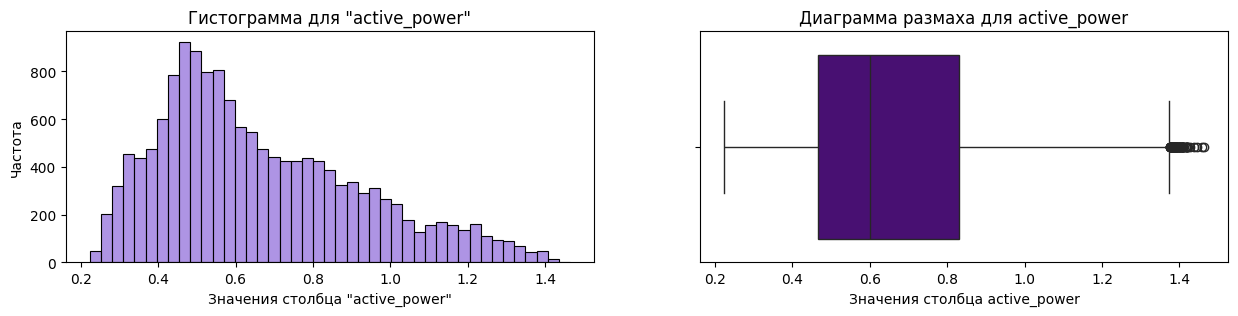

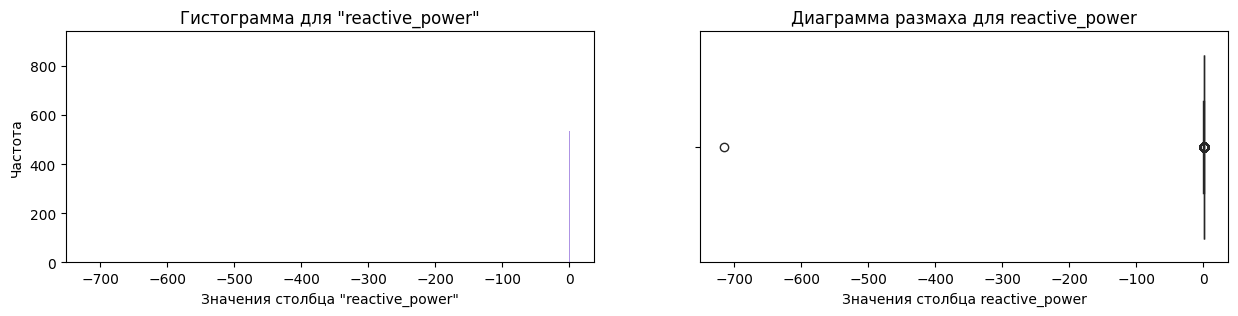

In [25]:
for name in num_col_arc:
    hist_box(arc, name)

В столбце `reactive_power` наблюдается выброс - отрицательное значение, которое не имеет смысла. Его нужно удалить.

In [26]:
arc = arc.query('reactive_power > 0')

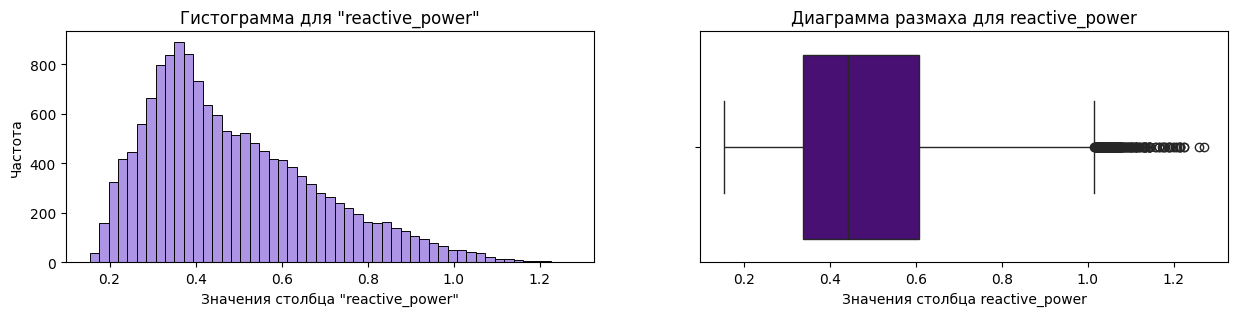

In [27]:
hist_box(arc, 'reactive_power')

Все признаки имеют практически нормальное распределение с длинным хвостом в диапазоне больших значений.

Значения, который boxplot посчитал выбросами, удалять не будем, поскольку они не противоречат сути данных - такие значения имеют место быть.

#### 2.1.2. датасет bulk

In [28]:
num_col_bulk = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

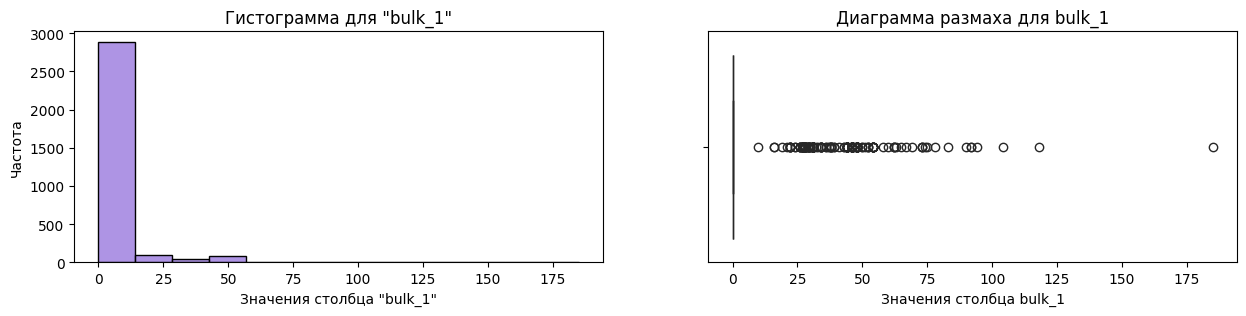

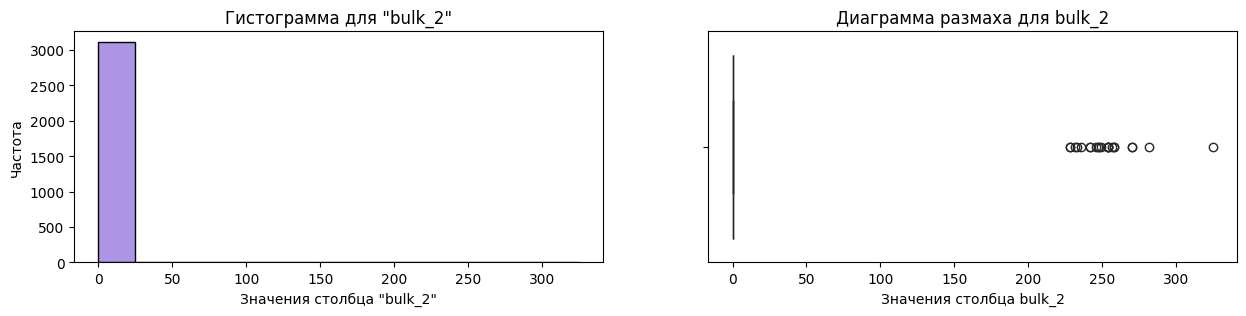

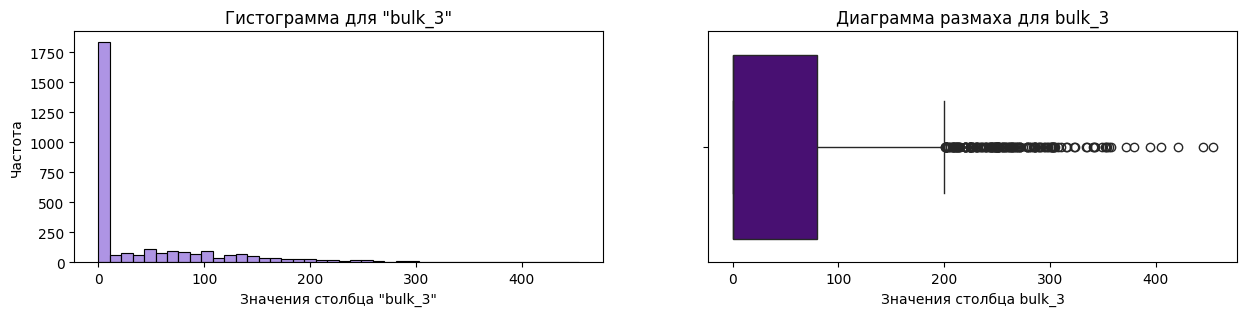

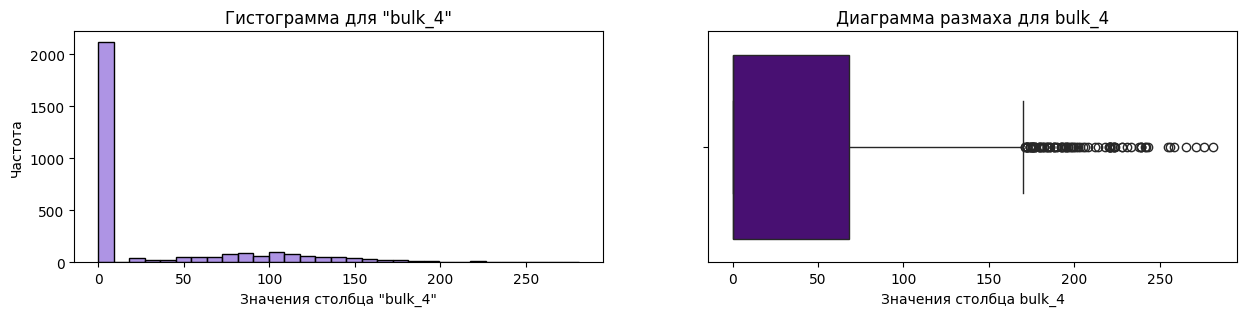

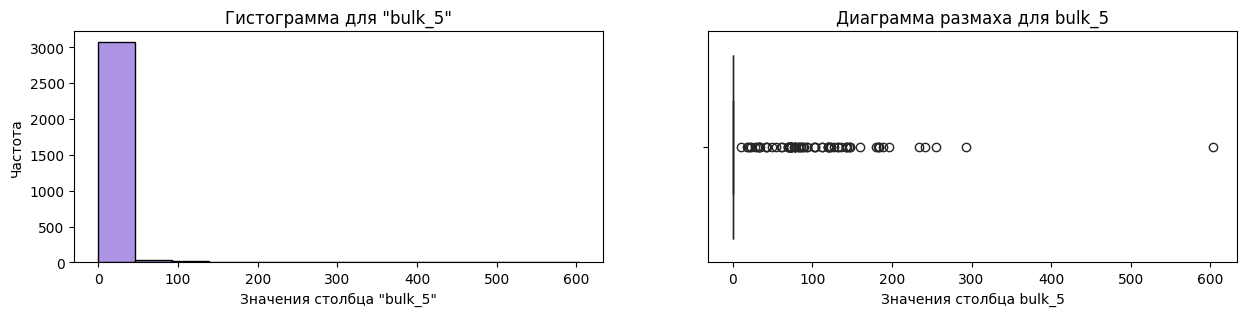

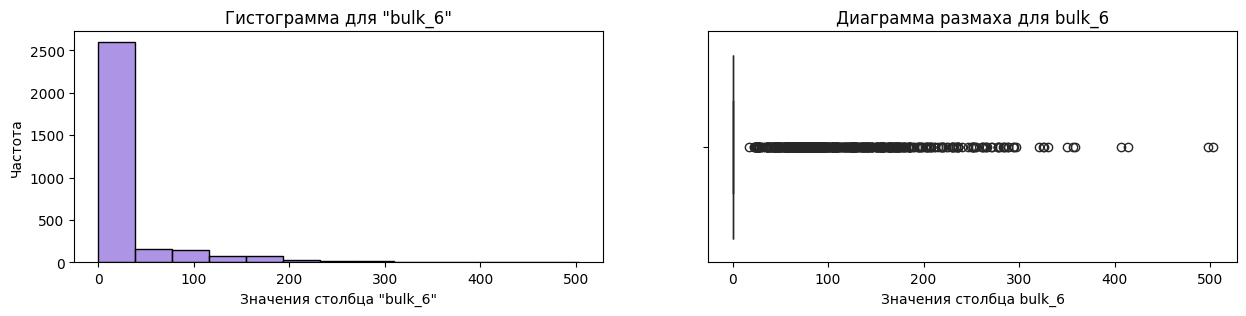

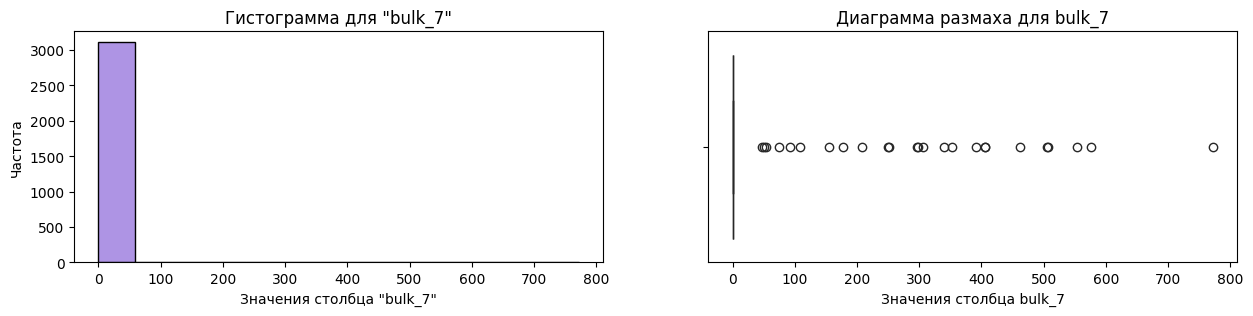

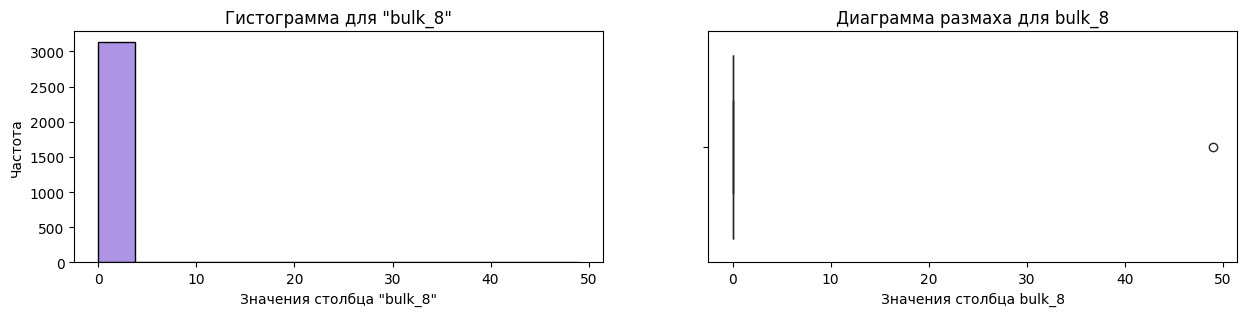

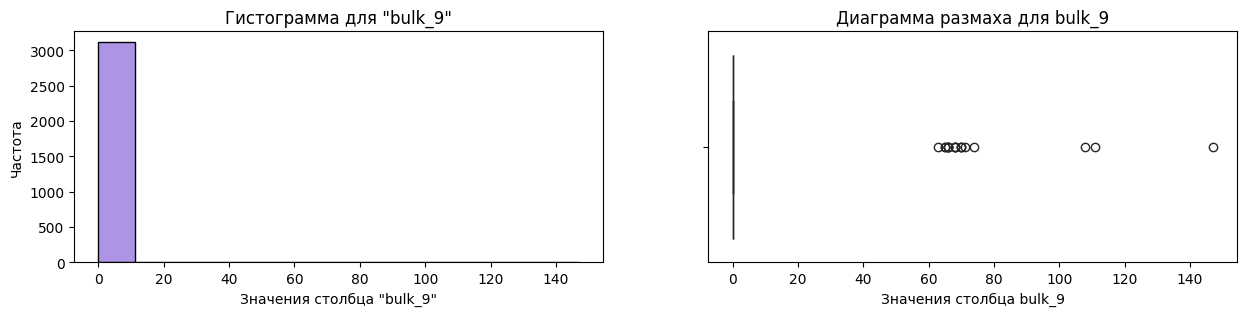

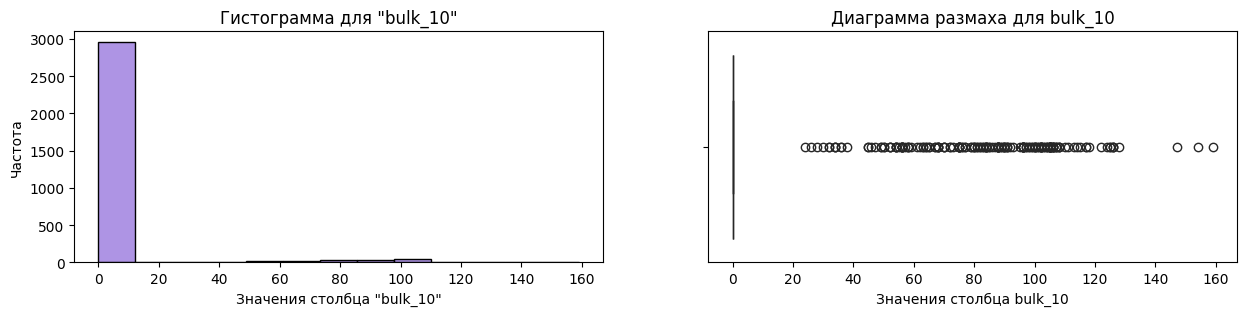

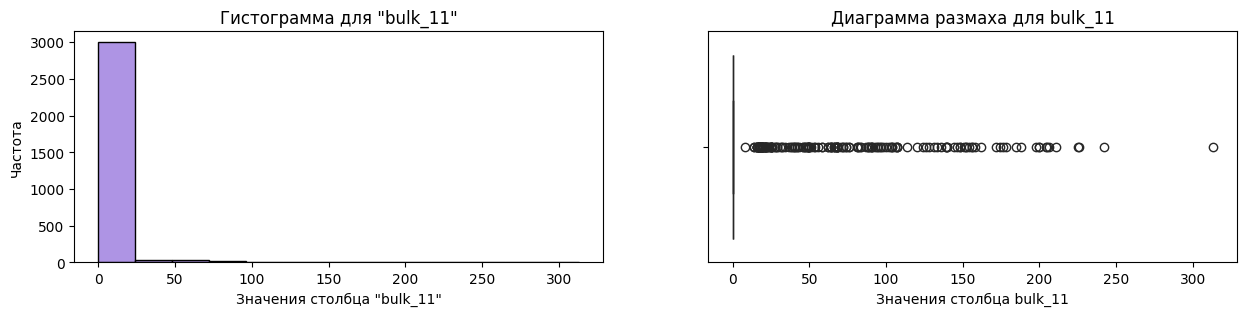

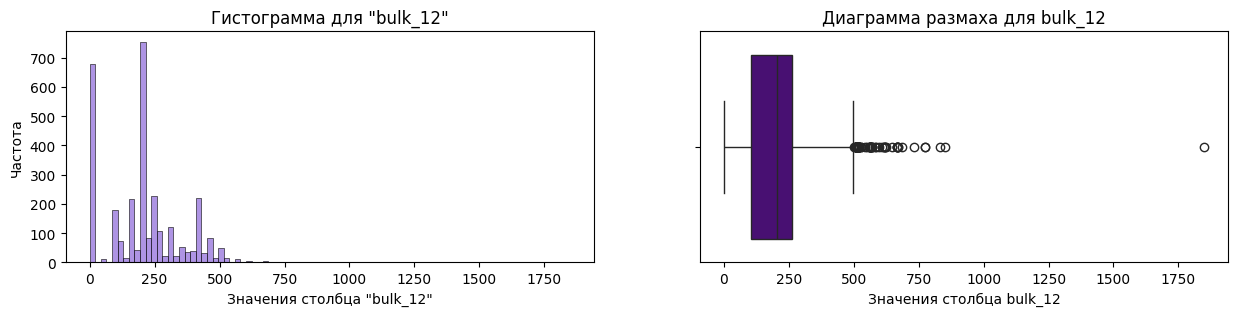

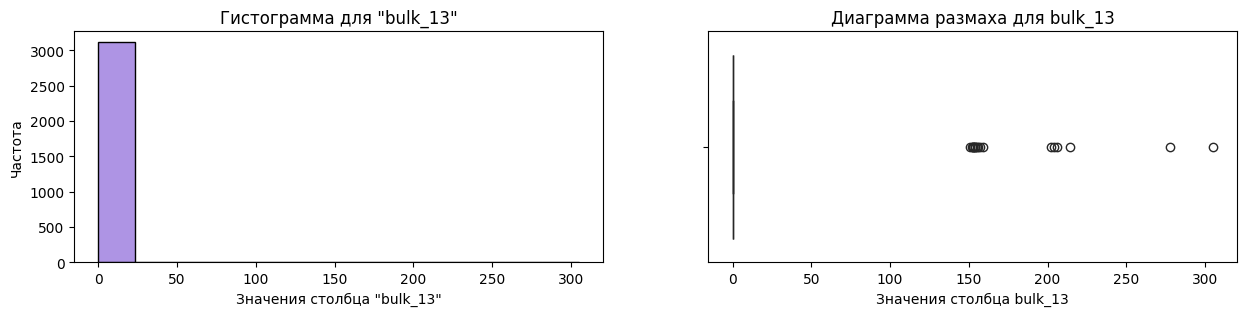

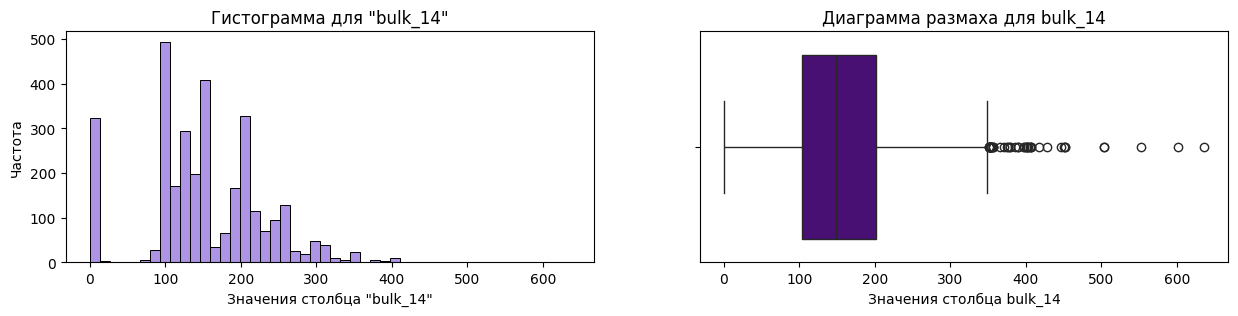

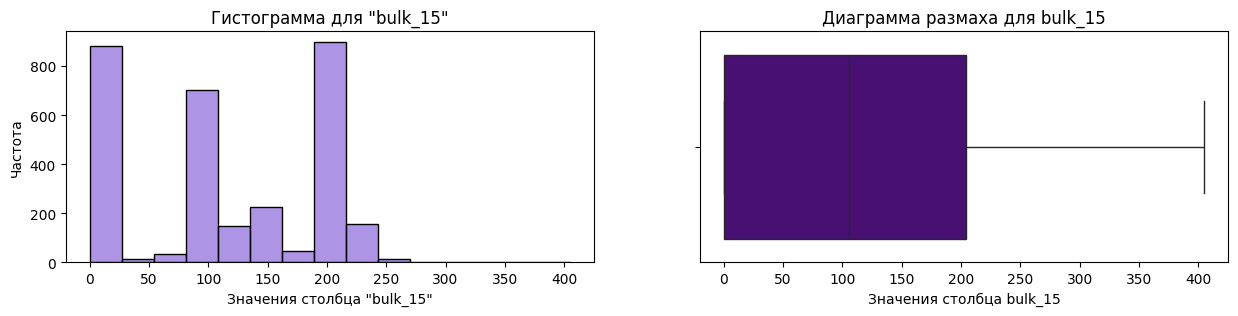

In [29]:
for name in num_col_bulk:
    hist_box(bulk, name)

Все признаки распределены неравномерно. По данным графика boxplot практически все они имеют статистические выбросы. Основную массу данных составляют значение около 0, что связано с заполненными пропусками.

Попробуем рассмотреть распределение данных без этих заглушек.

In [30]:
def hist_box_1(series, feature):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{feature}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{feature}"')
    sns.histplot(series, color='MediumPurple')
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {feature}')
    plt.title(f'Диаграмма размаха для {feature}')
    sns.boxplot(x=series, color='Indigo')

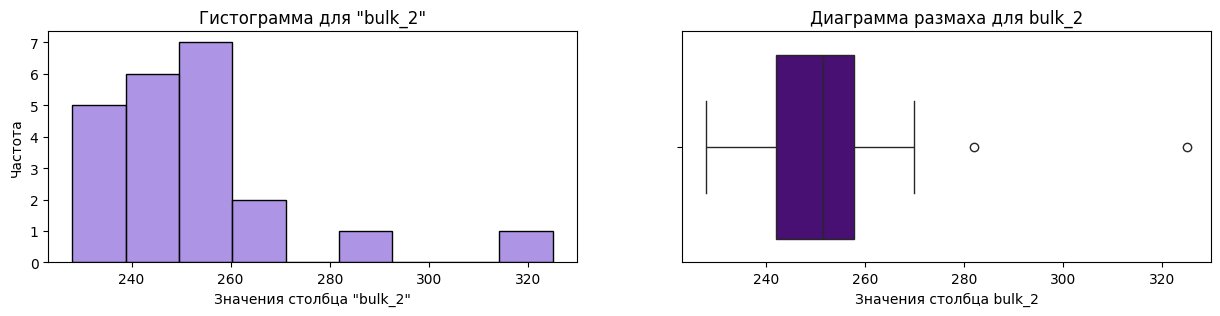

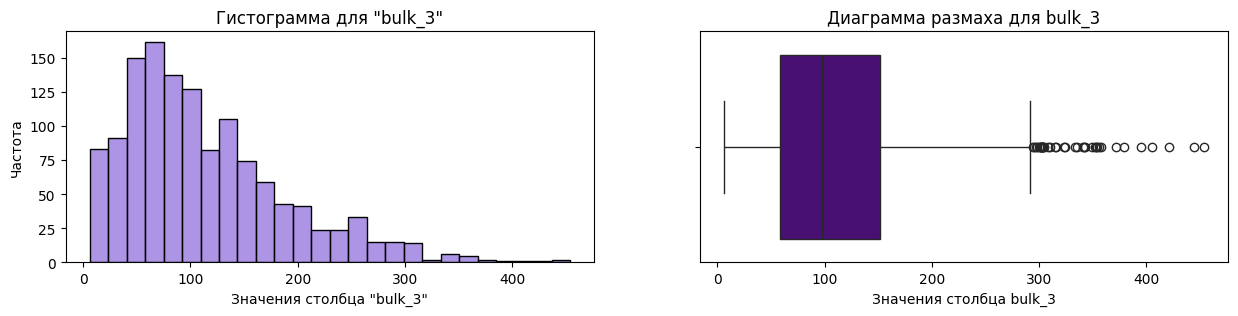

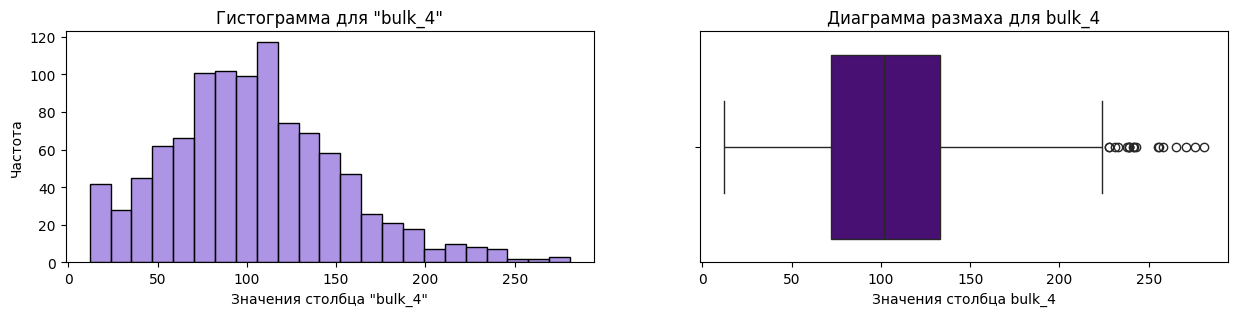

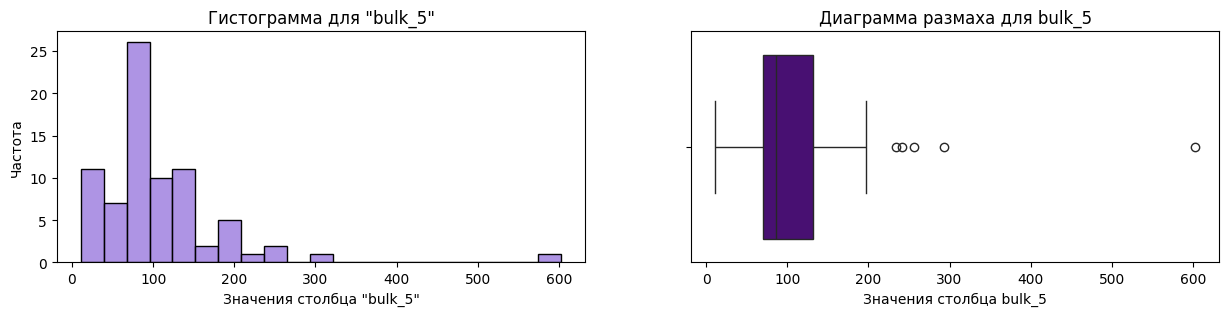

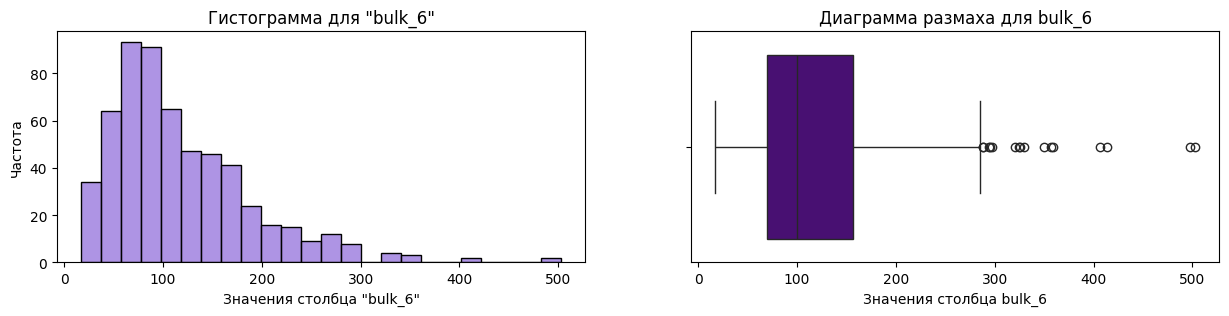

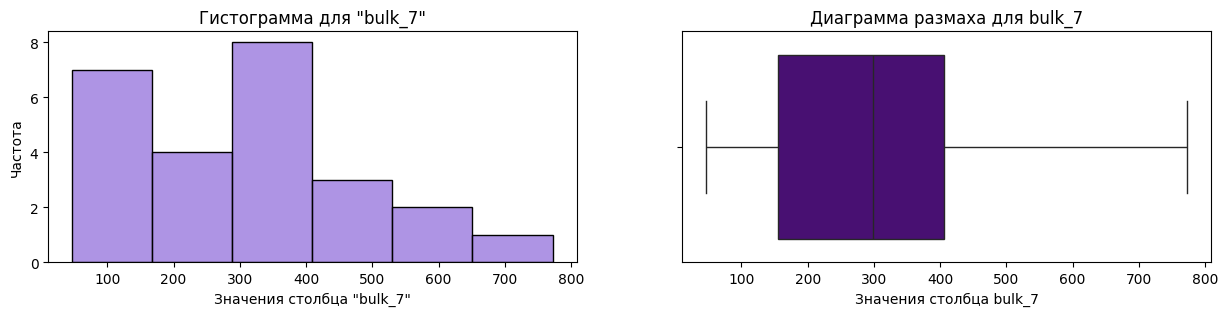

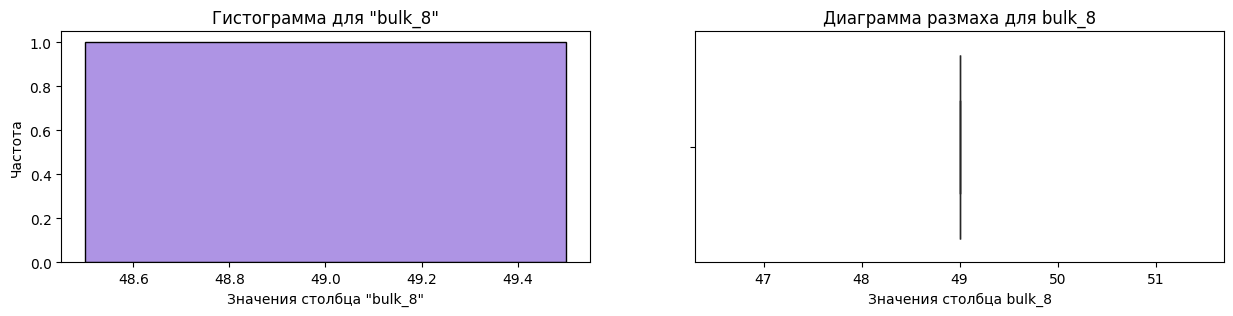

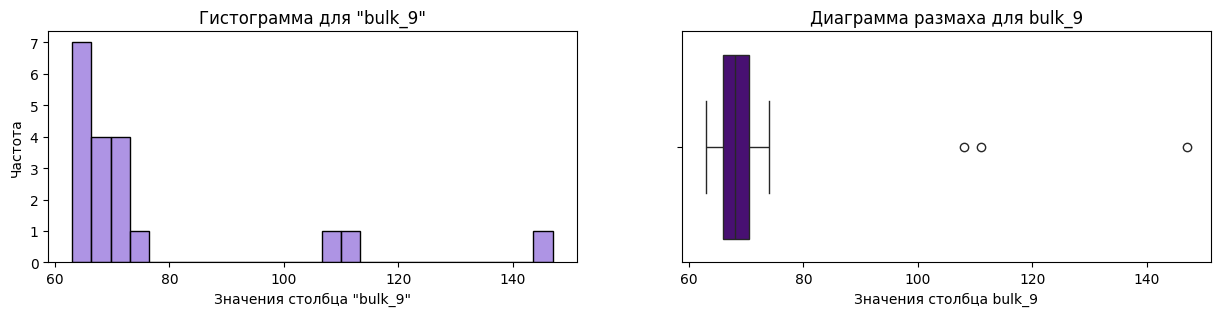

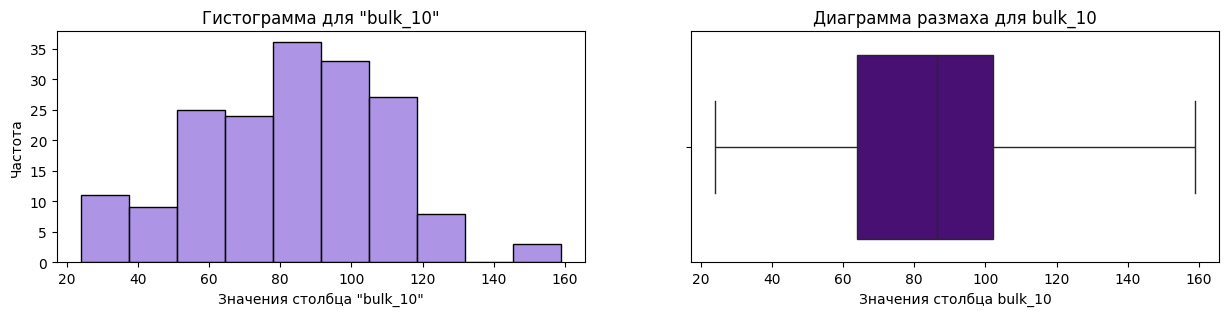

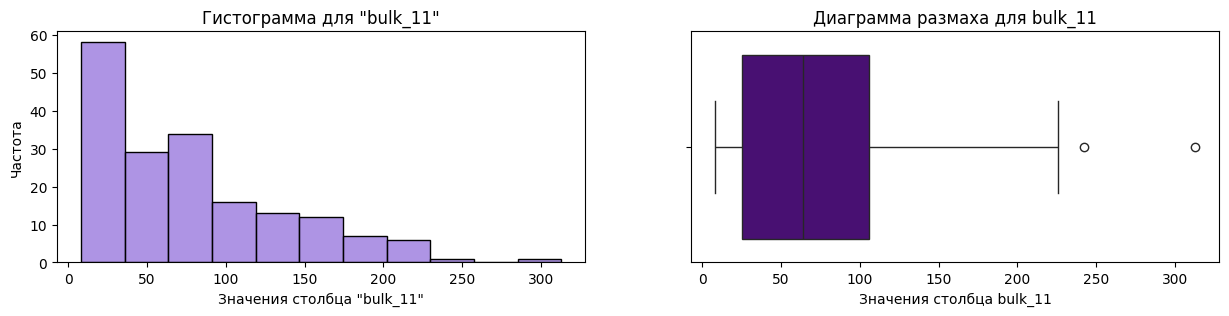

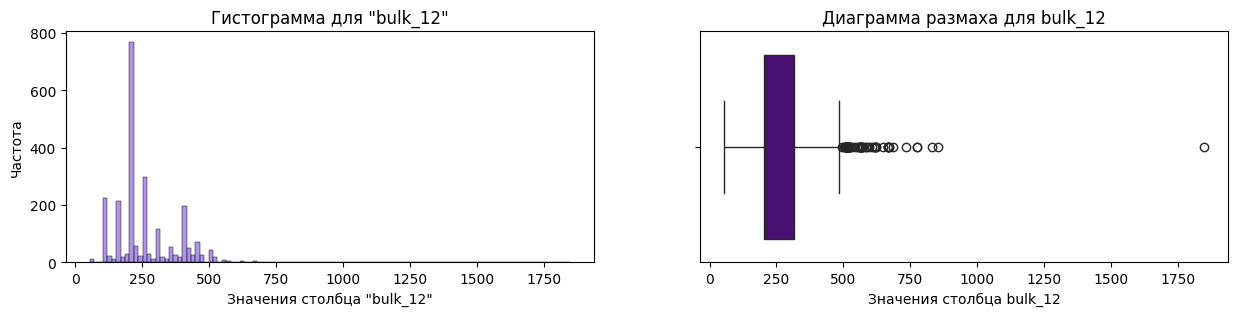

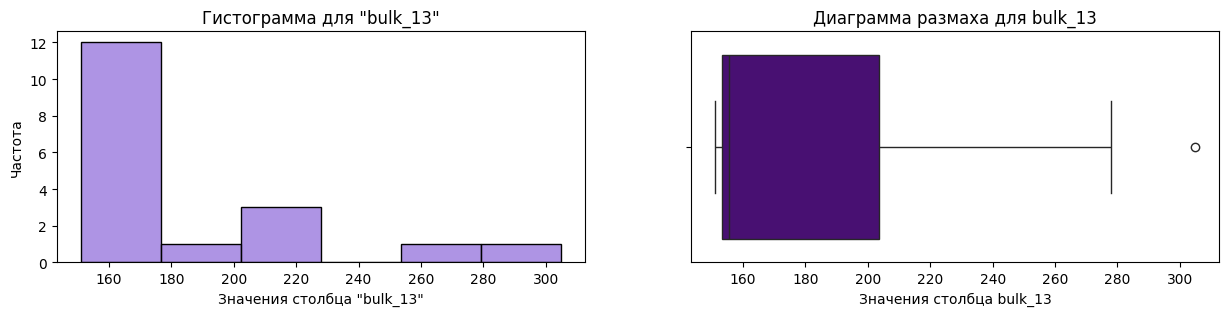

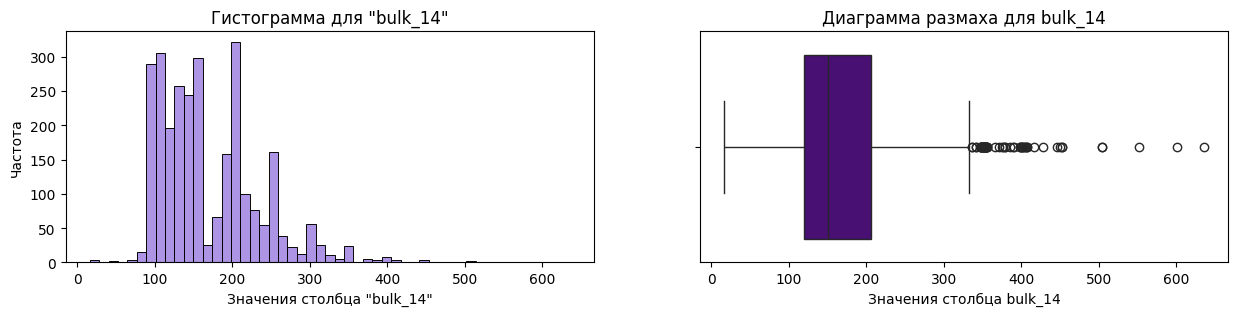

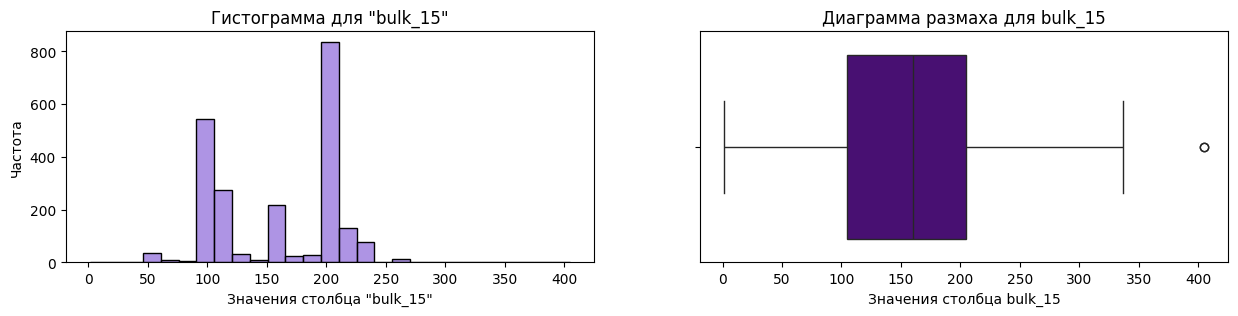

In [31]:
for name in num_col_bulk[1:]:
    res = bulk[bulk[name] > 0][name]
    hist_box_1(res, name)

Теперь некоторые признакие имеют что-то похожее на нормальное распределение! Для обучения берем все данные.

#### 2.1.3. датасет gas

In [32]:
num_col_gas = ['gas']

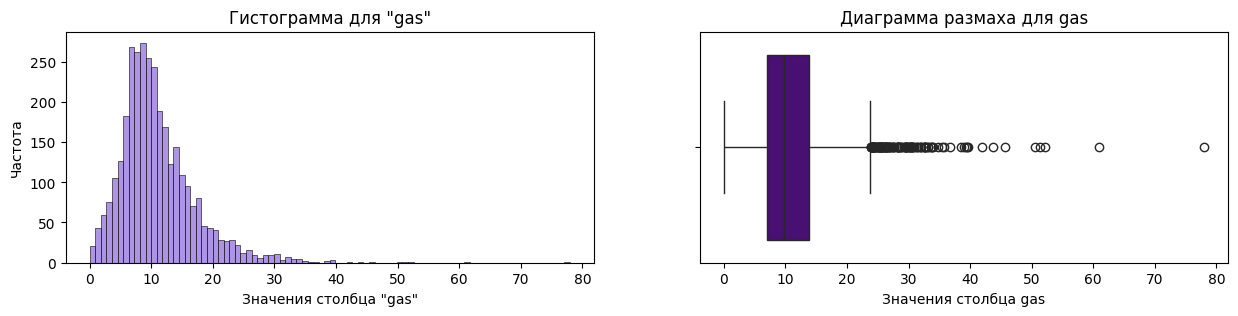

In [33]:
for name in num_col_gas:
    hist_box(gas, name)

Распределение признака похоже на нормальное с длинным хвостом в области больших значений. На данном этапе удалять не будем, рассмотрим статистические выбросы после объединения таблиц и разделения на тренировочную и тестовую выборки.

#### 2.1.4. датасет temp

In [34]:
num_col_temp = ['temperature']

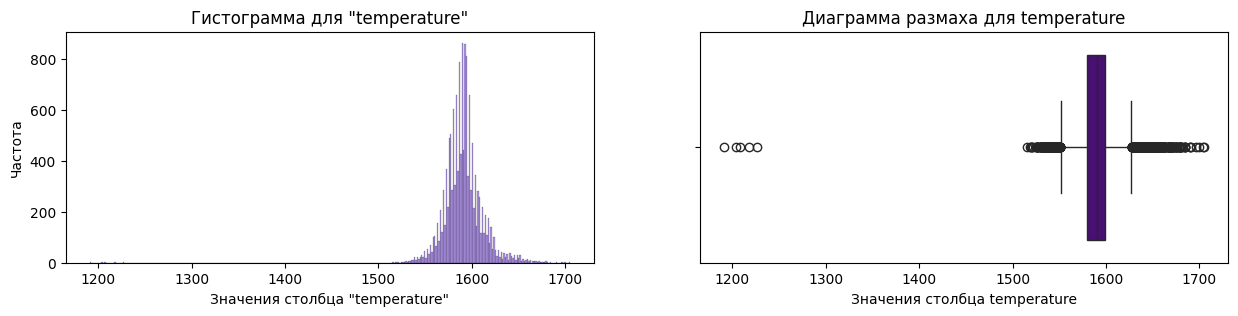

In [35]:
for name in num_col_temp:
    hist_box(temp, name)

Распределение целевого признака похоже на нормальное распределение. Имеются статистические выбросы. И таких значений очень мало - в начальных температурах 5 измерений, в конечной - одно. Их можно убрать - партии с такими значениями встречаются редко.

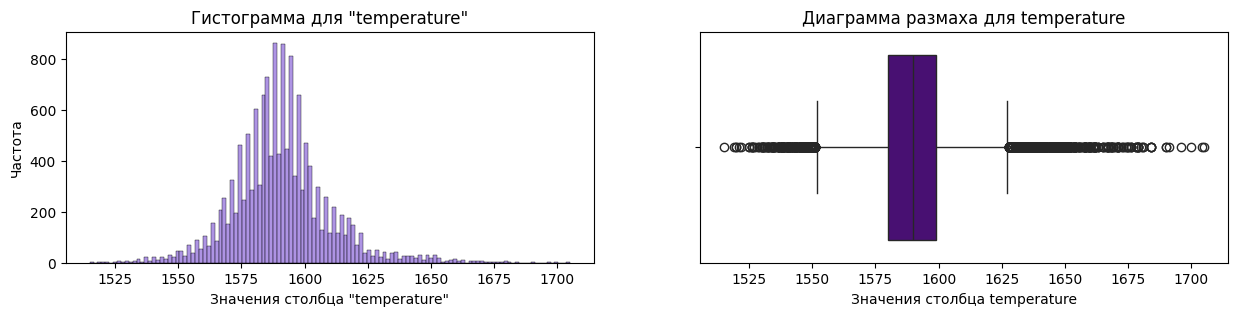

In [36]:
temp = temp.query('temperature > 1400')
for name in num_col_temp:
    hist_box(temp, name)

#### 2.1.5. датасет wire

In [37]:
num_col_wire = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                'wire_6', 'wire_7', 'wire_8', 'wire_9']

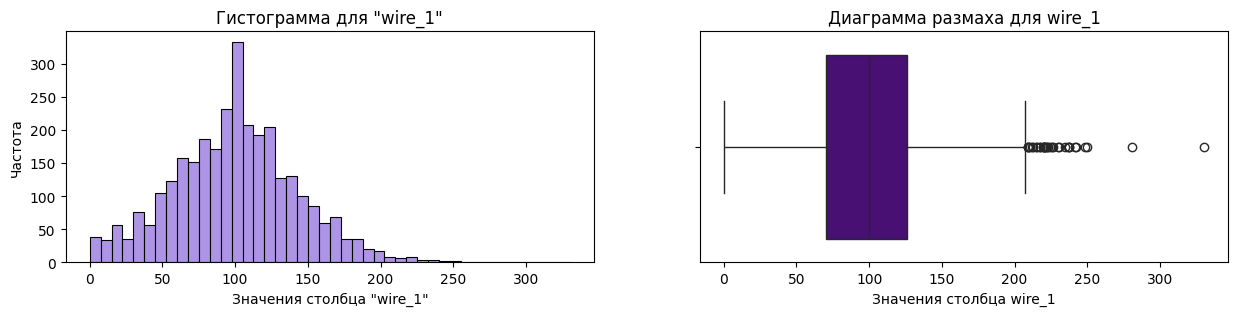

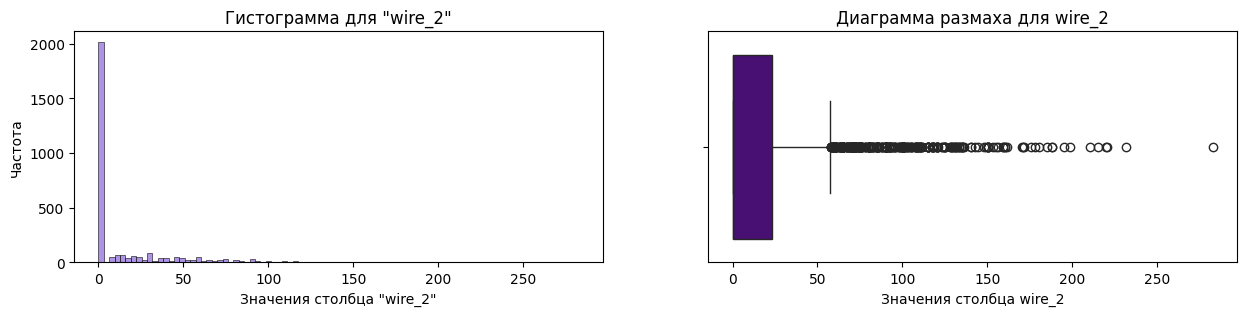

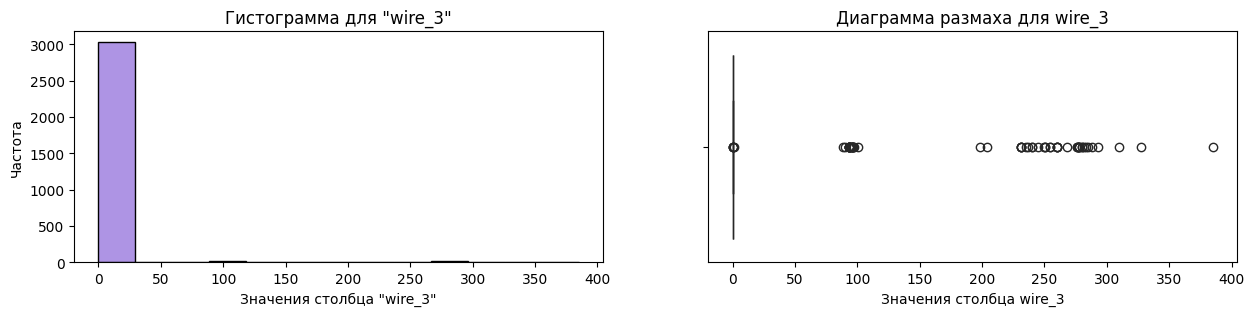

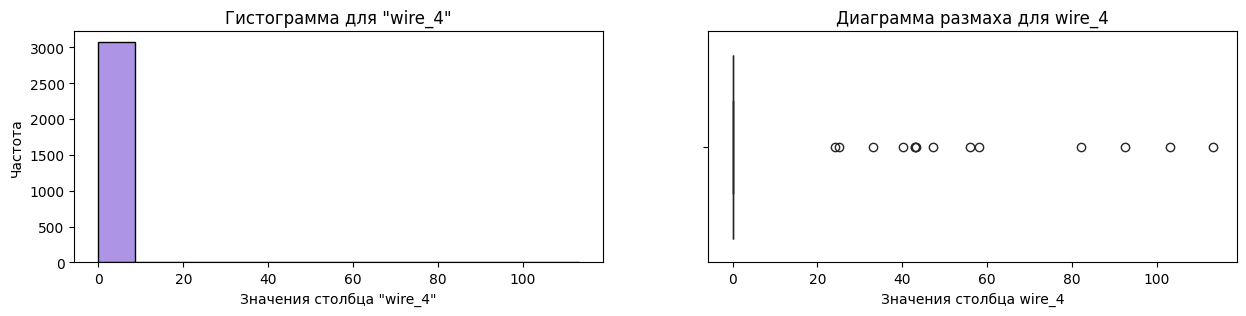

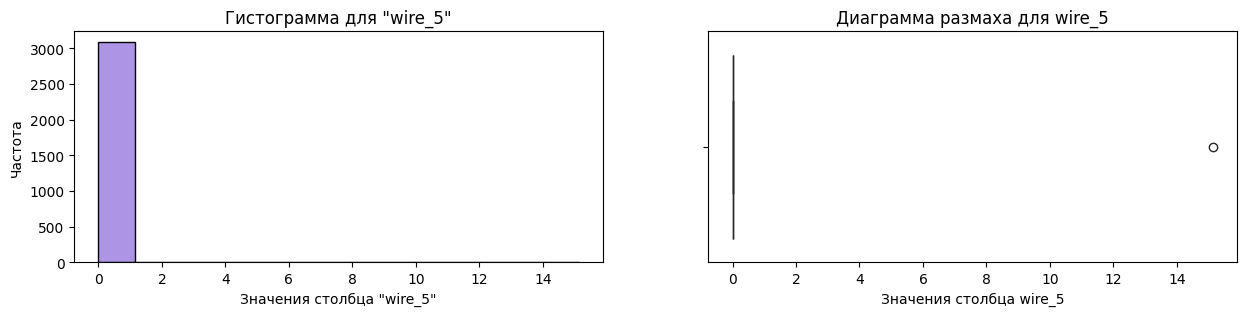

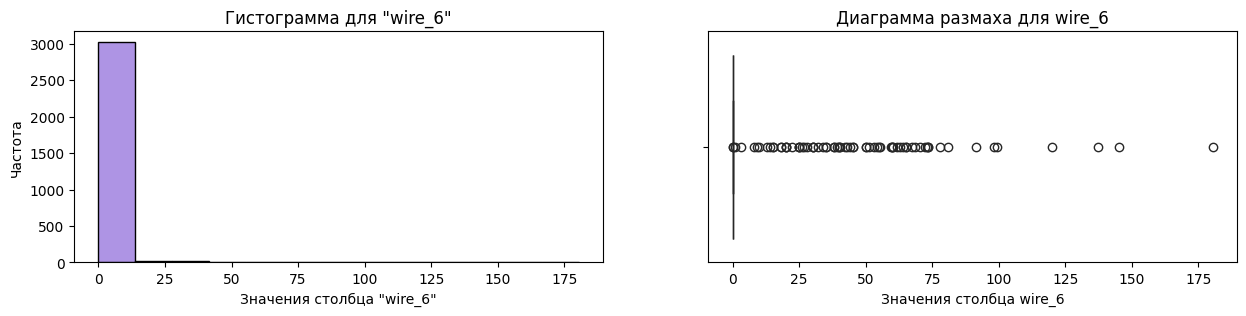

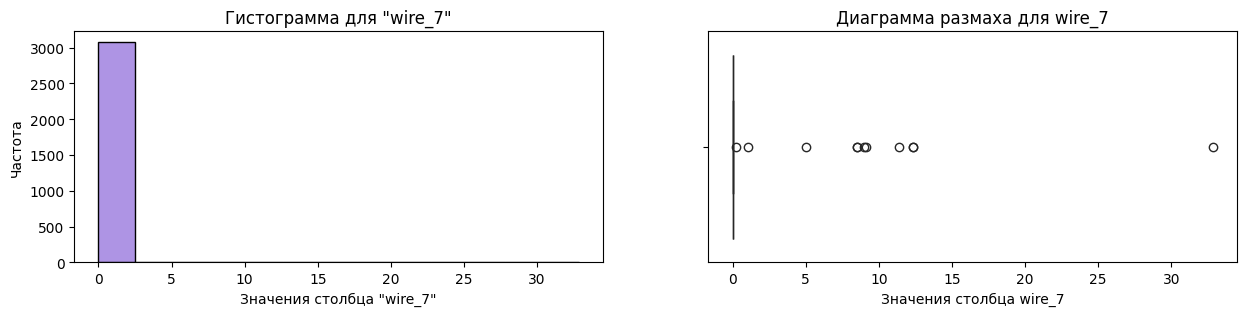

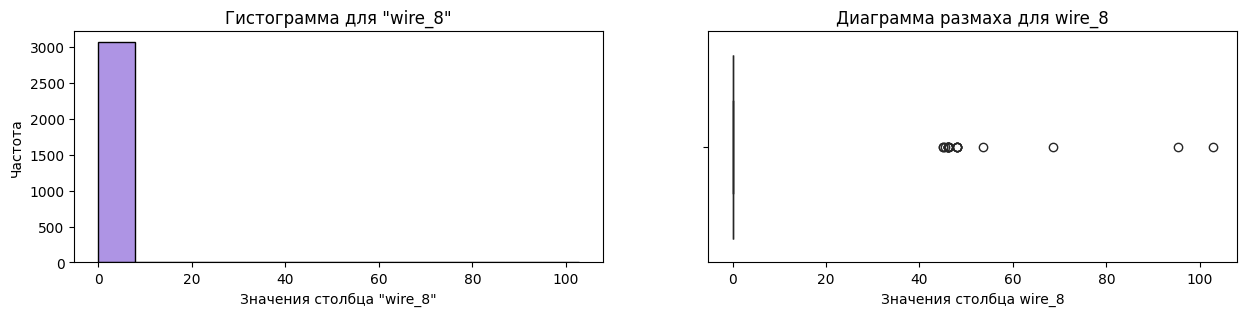

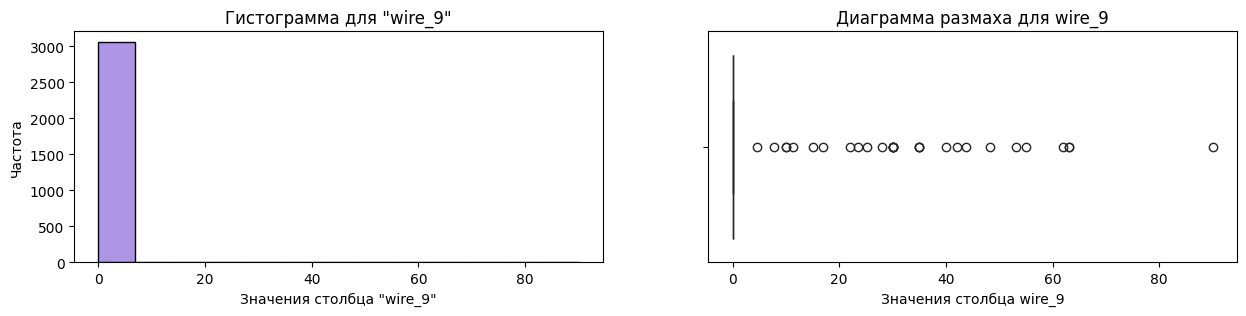

In [38]:
for name in num_col_wire:
    hist_box(wire, name)

Все признаки распределены неравномерно. По данным графика boxplot практически все они имеют статистические выбросы. Основную массу данных составляют значение около 0, что связано с заполненными пропусками.

Попробуем рассмотреть распределение данных без этих заглушек.

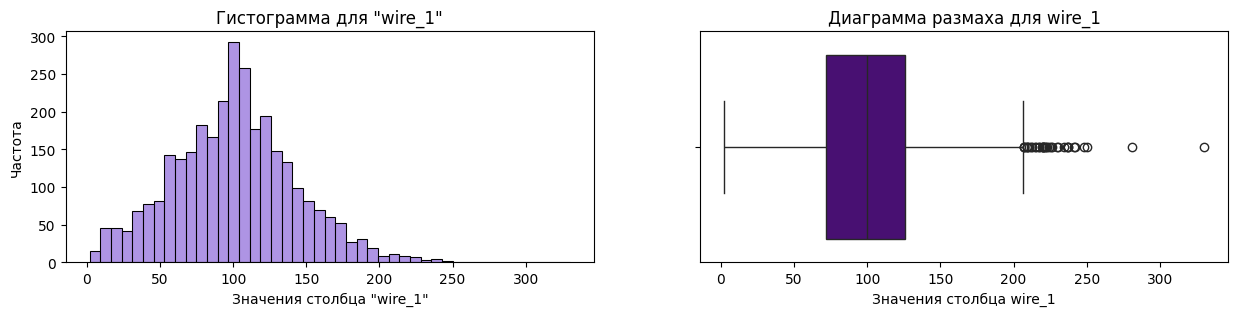

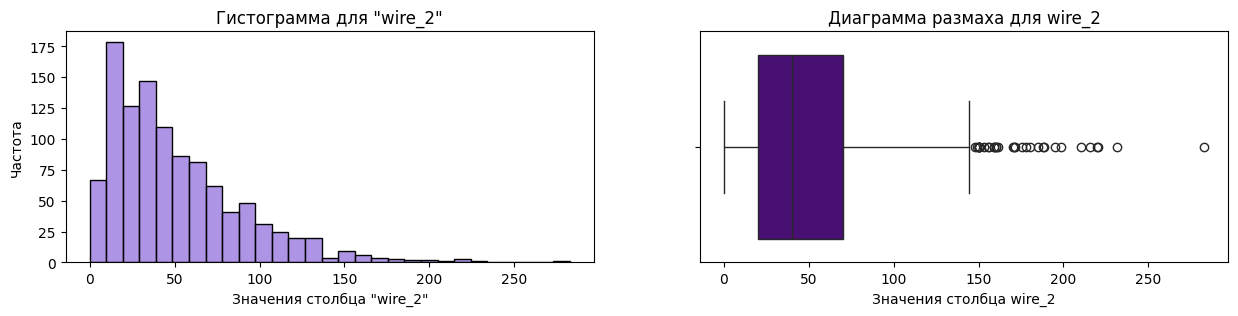

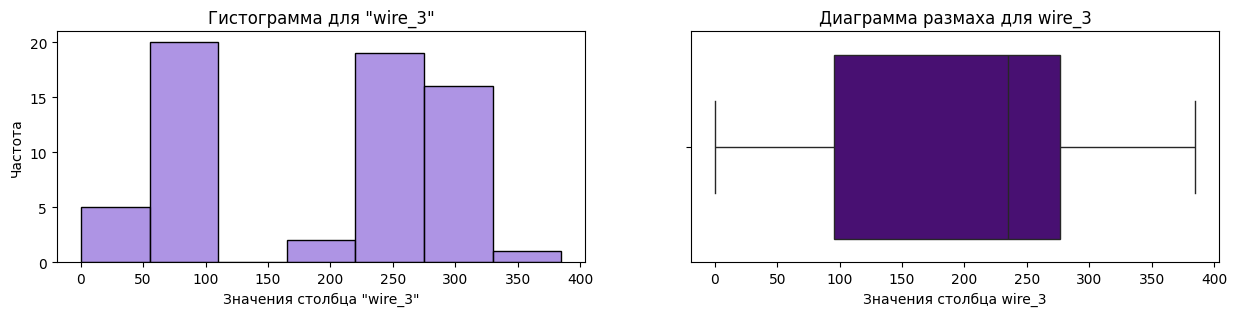

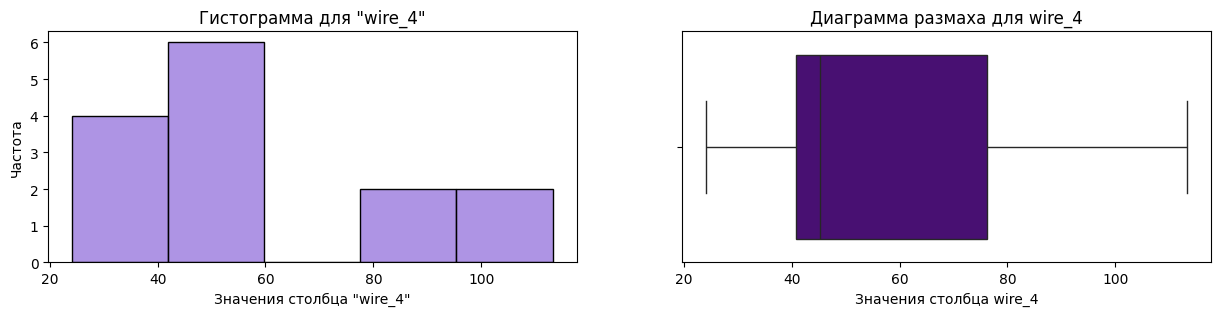

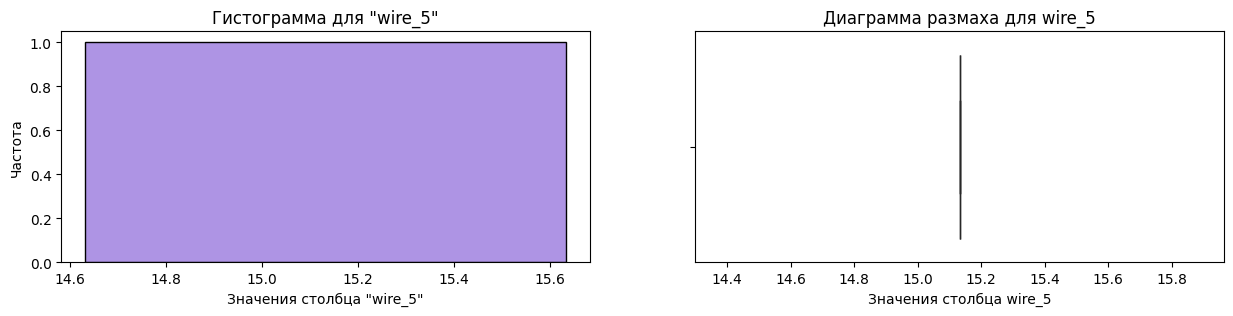

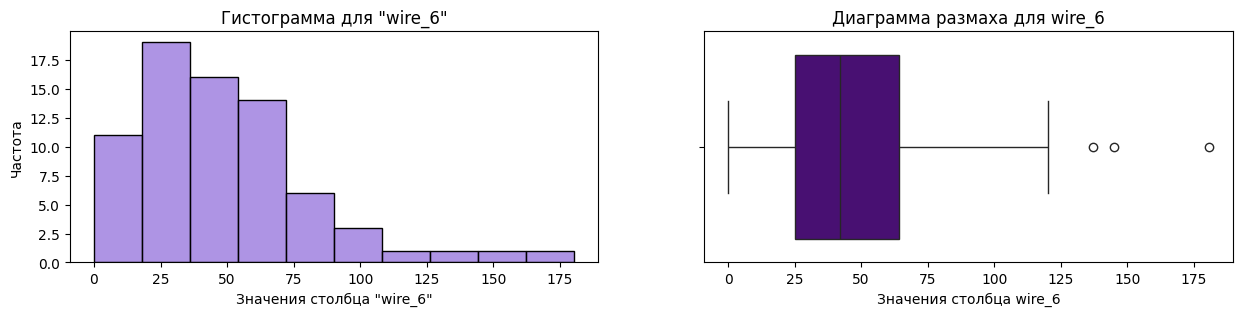

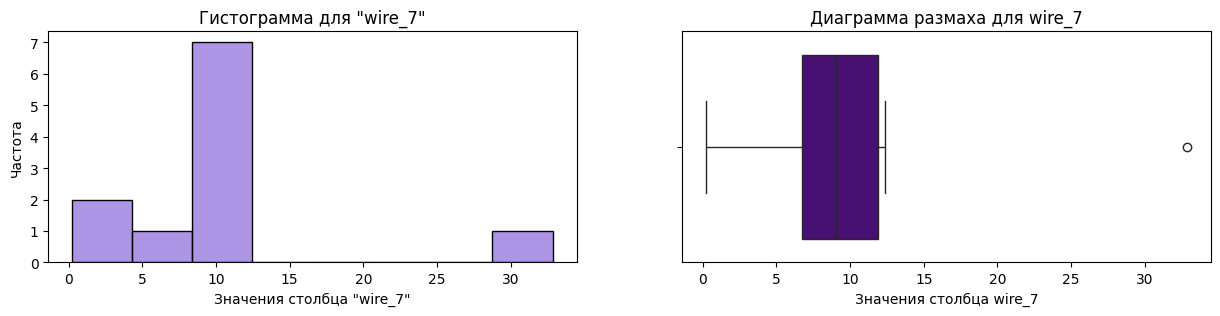

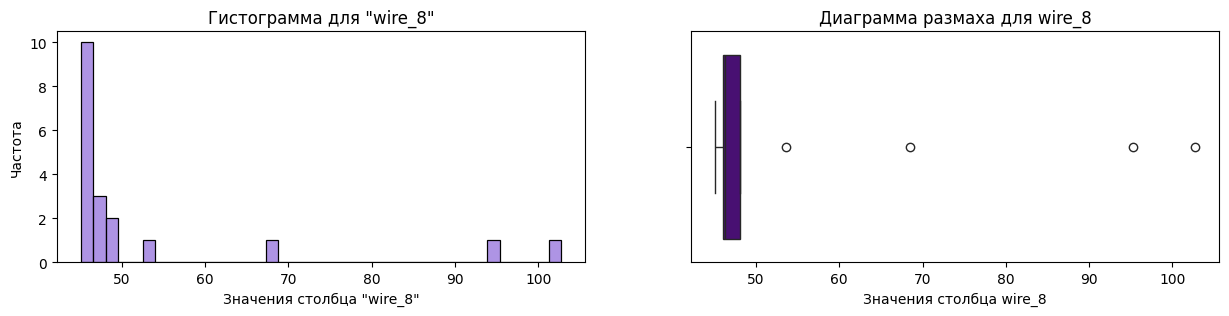

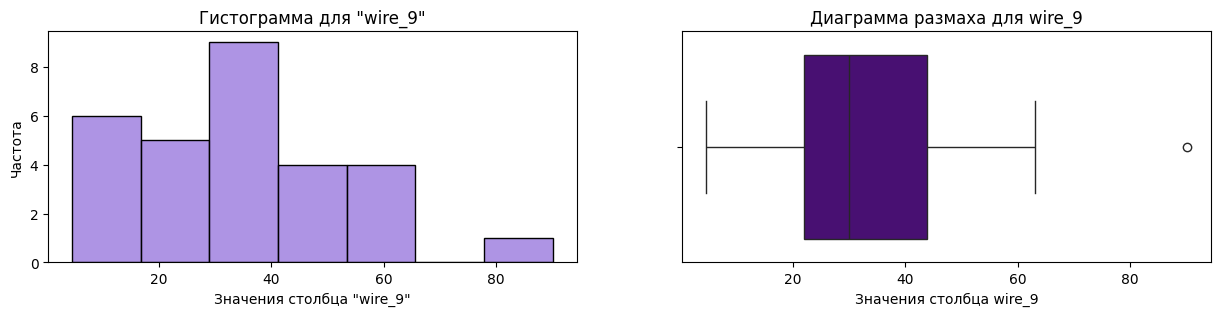

In [39]:
for name in num_col_wire:
    res = wire[wire[name] > 0][name]
    hist_box_1(res, name)

Теперь некоторые признакие имеют что-то похожее на нормальное распределение!
Но для обучения будем использовать все данные.

### 2.2. Корреляционный анализ

#### 2.2.1. датасет arc

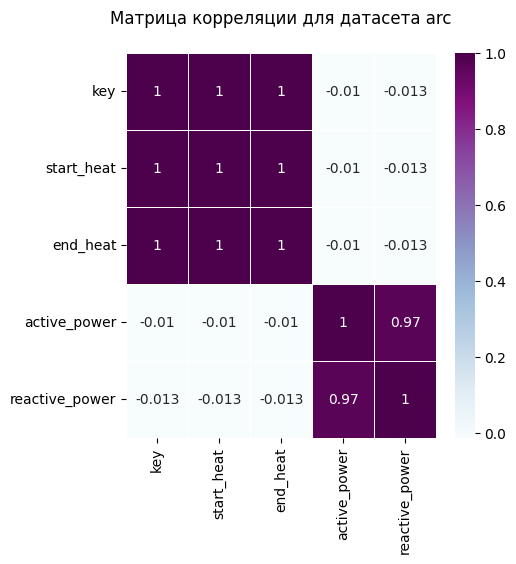

In [40]:
#вычисление матрицы корреляции
corr_matrix = arc.corr()

#визуализация матрицы корреляции
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', linewidth=.5)
plt.title('Матрица корреляции для датасета arc\n')
plt.show()

Наблюдается очень сильная корреляция между активной и реактивной мощностью. Стоит создать новый признак на основе этих двух - `full_power` - а от них избавиться. Это будет выполнено в разделе 3.1.

#### 2.2.2. датасет bulk

Поскольку признаки в данной таблице распределены ненормально, то вместо коэффициента корреляции Пирсона будем использовать коэффициент корреляции Спирмена.

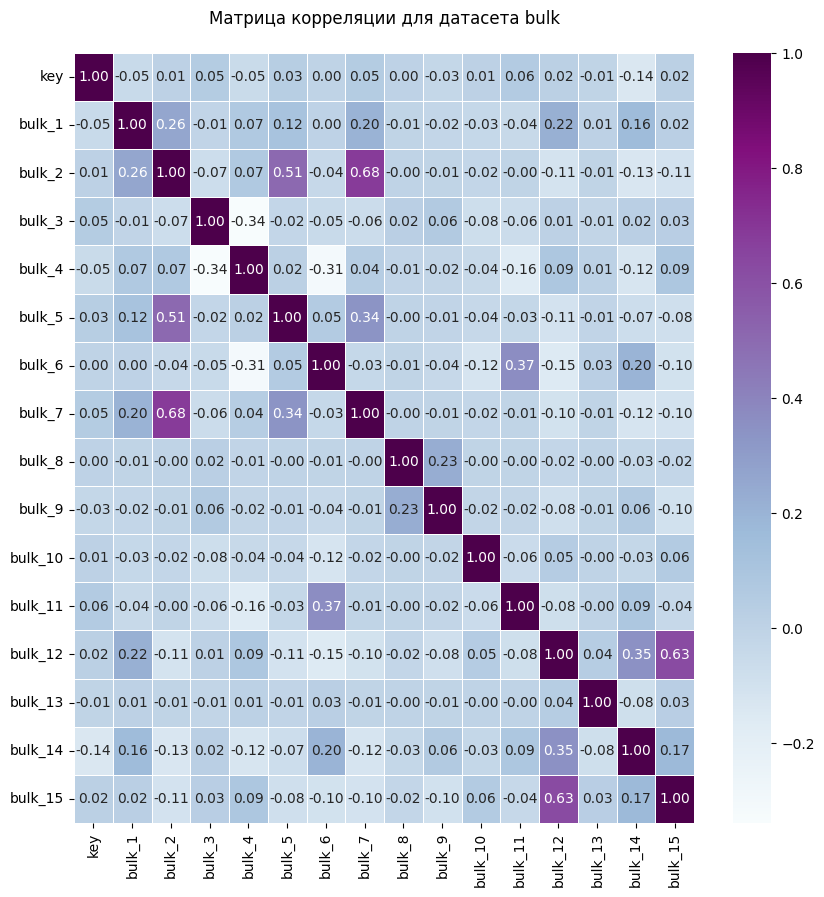

In [41]:
#вычисление матрицы корреляции
corr_matrix = bulk.corr(method='spearman')

#визуализация матрицы корреляции
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', linewidth=.5, fmt=".2f")
plt.title('Матрица корреляции для датасета bulk\n')
plt.show()

Наблюдается небольшая взаимосвязь между некоторыми признаки, но мультиколлениарности нет. Оставляем все признаки.

#### 2.2.3. датасет wire

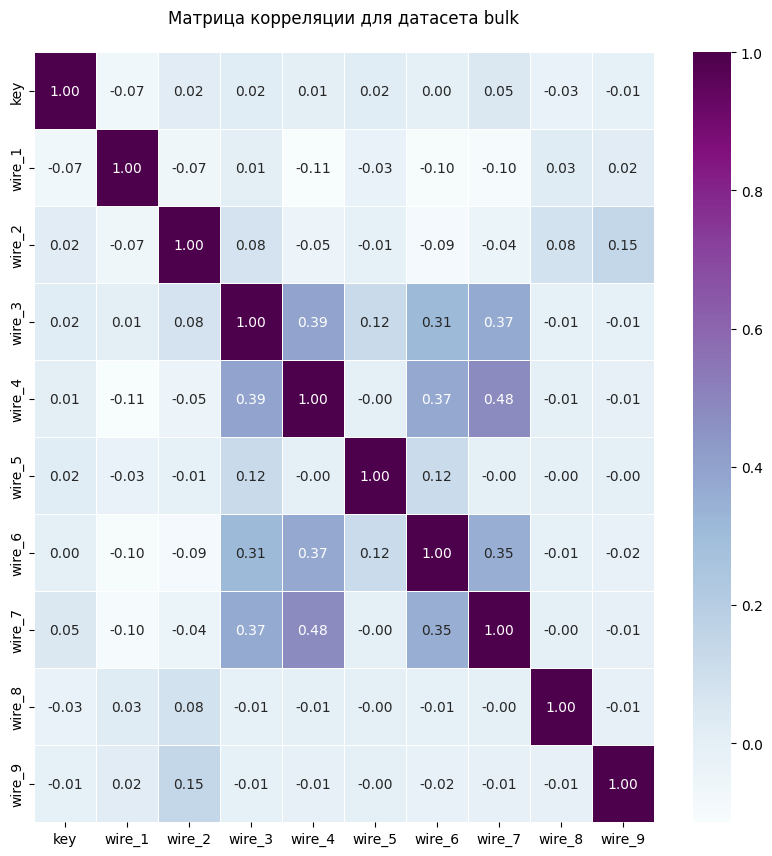

In [42]:
#вычисление матрицы корреляции
corr_matrix = wire.corr(method='spearman')

#визуализация матрицы корреляции
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', linewidth=.5, fmt=".2f")
plt.title('Матрица корреляции для датасета bulk\n')
plt.show()

Мультиколлениарности признаков не наблюдается.

### 2.3. Вывод

В данном разделе были выполнены следующие шаги:
- исследовано распределение количественных признаков во всех датасетах. Признаки в датасетах `bulk` и `wire` имеют ненормальное неравномерное распределение из-за большого количества нулей, что связано с пропусками в данных. В остальных датасетах признаки распределены нормально с длинным хвостом в области больших значений.
- проведен корреляционный анализ признаков. Выявлена сильная мультиколлениарность признаков `active_power` и `reactive_power`. Будет создан новый признак `full_power`. В остальных датасетах мультиколлениарности признаков не наблюдалось.

## 3. Объединение данных

### 3.1. Создание новых признаков и выбор нужных значений целевого признака

#### 3.1.1. датасет arc

В таблице `arc` для одной партии может содержаться несколько значений затрачиваемой мощности и несколько стадий нагрева. Поскольку мы берем в качестве целевого признака только конечную температуру, то таблицу `arc` стоит преобразовать:

- рассчитать количество циклов нагрева для каждой партии.

In [43]:
amount_heats = arc.groupby(by='key')['start_heat'].count()

- добавить время нагрева на основании данных о начале и конце нагрева. Получим время нагрева в секундах.

In [44]:
arc['start_heat'] = arc[['start_heat']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
arc['end_heat'] = arc[['end_heat']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
arc['time'] = (arc['end_heat'] - arc['start_heat']).astype(int)
arc.head()

key  start_heat    end_heat  active_power  reactive_power  time
0    1  1556881334  1556881562      0.305130        0.211253   228
1    1  1556881648  1556881833      0.765658        0.477438   185
2    1  1556881904  1556882076      0.580313        0.430460   172
3    1  1556882294  1556882659      0.518496        0.379979   365
4    1  1556882769  1556882917      0.867133        0.643691   148

- рассчитать полную затрачеваемую мощность, которая рассчитывается по формуле:

        S = √P²+Q²
    
где S - полная мощность, P - активная мощность, Q - реактивная мощность.

In [45]:
arc['full_power'] = (arc['active_power']**2 + arc['reactive_power']**2)**0.5
arc.head()

key  start_heat    end_heat  active_power  reactive_power  time  full_power
0    1  1556881334  1556881562      0.305130        0.211253   228    0.371123
1    1  1556881648  1556881833      0.765658        0.477438   185    0.902319
2    1  1556881904  1556882076      0.580313        0.430460   172    0.722536
3    1  1556882294  1556882659      0.518496        0.379979   365    0.642824
4    1  1556882769  1556882917      0.867133        0.643691   148    1.079934

- зная время нагрева и полную мощность можно рассчитать совершаемую работу - она равна произведению мощности на время.

In [46]:
arc['work'] = arc['time'] * arc['full_power']
arc.head()

key  start_heat    end_heat  active_power  reactive_power  time  \
0    1  1556881334  1556881562      0.305130        0.211253   228   
1    1  1556881648  1556881833      0.765658        0.477438   185   
2    1  1556881904  1556882076      0.580313        0.430460   172   
3    1  1556882294  1556882659      0.518496        0.379979   365   
4    1  1556882769  1556882917      0.867133        0.643691   148   

   full_power        work  
0    0.371123   84.616003  
1    0.902319  166.928978  
2    0.722536  124.276277  
3    0.642824  234.630603  
4    1.079934  159.830252

- рассчитать суммарные затраченные мощности и время для достижения конечной температуры партии. И убрать столбцы с данными о начале и конце нагрева.

In [47]:
arc = arc.groupby(by='key')[['active_power', 'reactive_power', 'time', 'full_power', 'work']].sum()
arc.head()

active_power  reactive_power  time  full_power        work
key                                                            
1        3.036730        2.142821  1098    3.718736  770.282114
2        2.139408        1.453357   811    2.588349  481.760005
3        4.063641        2.937457   655    5.019223  722.837668
4        2.706489        2.056992   741    3.400038  683.455597
5        2.252950        1.687991   869    2.816980  512.169934

- добавить столбец с количеством циклом нагрева для каждой партии.

In [48]:
arc = arc.join(amount_heats)
arc = arc.rename(columns={'start_heat':'amount_heat'})
arc = arc[['time', 'full_power', 'work', 'amount_heat']]
arc.head()

time  full_power        work  amount_heat
key                                           
1    1098    3.718736  770.282114            5
2     811    2.588349  481.760005            4
3     655    5.019223  722.837668            5
4     741    3.400038  683.455597            4
5     869    2.816980  512.169934            4

#### 3.1.2. датасет temp

По желанию заказчика предсказывать нужно только конечную температуру в партии. Поэтому таблицу `temp` необходимо очистить и оставить только нужные температуры. Но начальную температуру партии можно взять как входной признак. Также в качестве нового признака добавим время между первым и последним замером температуры в партии.

In [49]:
temp.groupby(by='key')['time'].count()

key
1       6
2       5
3       6
4       5
5       5
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: time, Length: 3215, dtype: int64

В некоторых партиях встречается всего по одному замерy температуры, поэтому для этих партий мы не сможем выделить значения начальных температур. Поэтому эти партии придется удалить.

In [50]:
m_counts = temp.groupby(by='key')['time'].count()

In [51]:
temp = temp.merge(m_counts, on='key')
temp = temp.query('time_y > 1')
temp

key              time_x  temperature  time_y
0         1 2019-05-03 11:02:04       1571.0       6
1         1 2019-05-03 11:07:18       1604.0       6
2         1 2019-05-03 11:11:34       1618.0       6
3         1 2019-05-03 11:18:04       1601.0       6
4         1 2019-05-03 11:25:59       1606.0       6
...     ...                 ...          ...     ...
13917  2499 2019-08-10 13:33:21       1569.0       5
13918  2499 2019-08-10 13:41:34       1604.0       5
13919  2499 2019-08-10 13:46:28       1593.0       5
13920  2499 2019-08-10 13:54:56       1588.0       5
13921  2499 2019-08-10 13:58:58       1603.0       5

[13920 rows x 4 columns]

In [52]:
temp_init = temp.groupby(by="key")['time_x'].min() #времена замера начальной температуры
temp_end = temp.groupby(by="key")['time_x'].max() #времена замера конечной температуры температуры

In [53]:
t_init = temp.query('time_x in @temp_init')

In [54]:
t_end = temp.query('time_x in @temp_end')

In [55]:
temp = t_init.merge(t_end, on='key', how='left').set_index('key')
temp

time_x_x  temperature_x  time_y_x            time_x_y  \
key                                                                     
1    2019-05-03 11:02:04         1571.0         6 2019-05-03 11:30:38   
2    2019-05-03 11:34:04         1581.0         5 2019-05-03 11:55:09   
3    2019-05-03 12:06:44         1596.0         6 2019-05-03 12:35:57   
4    2019-05-03 12:39:27         1601.0         5 2019-05-03 12:59:47   
5    2019-05-03 13:11:03         1576.0         5 2019-05-03 13:36:39   
...                  ...            ...       ...                 ...   
2495 2019-08-10 11:27:47         1570.0         5 2019-08-10 11:50:47   
2496 2019-08-10 11:56:48         1554.0         7 2019-08-10 12:25:13   
2497 2019-08-10 12:37:26         1571.0         4 2019-08-10 12:53:28   
2498 2019-08-10 12:58:11         1591.0         6 2019-08-10 13:23:31   
2499 2019-08-10 13:33:21         1569.0         5 2019-08-10 13:58:58   

      temperature_y  time_y_y  
key                            
1            1613.0         6  
2            1602.0         5  
3            1599.0         6  
4            1625.0         5  
5            1602.0         5  
...             ...       ...  
2495         1591.0         5  
2496         1591.0         7  
2497         1589.0         4  
2498         1594.0         6  
2499         1603.0         5  

[2475 rows x 6 columns]

In [56]:
temp = temp.rename(columns={'temperature_x':'init_temp',
                            'temperature_y':'end_temp',
                            'time_x_x':'init_time',
                            'time_x_y':'end_time',
                            'time_y_x':'measure_count'})
temp.head()

init_time  init_temp  measure_count            end_time  \
key                                                                     
1   2019-05-03 11:02:04     1571.0              6 2019-05-03 11:30:38   
2   2019-05-03 11:34:04     1581.0              5 2019-05-03 11:55:09   
3   2019-05-03 12:06:44     1596.0              6 2019-05-03 12:35:57   
4   2019-05-03 12:39:27     1601.0              5 2019-05-03 12:59:47   
5   2019-05-03 13:11:03     1576.0              5 2019-05-03 13:36:39   

     end_temp  time_y_y  
key                      
1      1613.0         6  
2      1602.0         5  
3      1599.0         6  
4      1625.0         5  
5      1602.0         5

In [57]:
temp['init_time'] = temp[['init_time']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
temp['end_time'] = temp[['end_time']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
temp['time_temp'] = (temp['end_time'] - temp['init_time']).astype(int)

In [58]:
temp = temp[['init_temp', 'end_temp', 'time_temp']]
temp

init_temp  end_temp  time_temp
key                                 
1        1571.0    1613.0       1714
2        1581.0    1602.0       1265
3        1596.0    1599.0       1753
4        1601.0    1625.0       1220
5        1576.0    1602.0       1536
...         ...       ...        ...
2495     1570.0    1591.0       1380
2496     1554.0    1591.0       1705
2497     1571.0    1589.0        962
2498     1591.0    1594.0       1520
2499     1569.0    1603.0       1537

[2475 rows x 3 columns]

### 3.2. Объединение таблиц

Перед обучением моделей МО необходимо объединить все необходимые признаки и целевую переменную в одну таблицу. В итоге должны остаться только данные по тем партиям, по которым есть значения целевого признака. Поэтому будем объединять таблицу с температурами со всеми остальными с помощью `join`.

1. Для начала сделаем во всех таблицах значения столбца `key` индексами датасетов.

In [59]:
bulk = bulk.set_index('key')
bulk.head()

bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
key                                                        
1        0.0      0.0    206.0      0.0    150.0    154.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0    205.0      0.0    152.0    153.0  
4        0.0      0.0    207.0      0.0    153.0    154.0  
5        0.0      0.0    203.0      0.0    151.0    152.0

In [60]:
gas = gas.set_index('key')
gas.head()

gas
key           
1    29.749986
2    12.555561
3    28.554793
4    18.841219
5     5.413692

In [61]:
wire = wire.set_index('key')
wire.head()

wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                       
1    60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5    89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     wire_9  
key          
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0

2. Объединяем

In [62]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2475 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   init_temp  2475 non-null   float64
 1   end_temp   2475 non-null   float64
 2   time_temp  2475 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


В конечном таблице должно быть такое же количество строк - 2475.

In [63]:
temp = temp.join(arc)
temp.head()

init_temp  end_temp  time_temp  time  full_power        work  amount_heat
key                                                                           
1       1571.0    1613.0       1714  1098    3.718736  770.282114            5
2       1581.0    1602.0       1265   811    2.588349  481.760005            4
3       1596.0    1599.0       1753   655    5.019223  722.837668            5
4       1601.0    1625.0       1220   741    3.400038  683.455597            4
5       1576.0    1602.0       1536   869    2.816980  512.169934            4

In [64]:
temp = temp.join(bulk)
temp.head()

init_temp  end_temp  time_temp  time  full_power        work  \
key                                                                 
1       1571.0    1613.0       1714  1098    3.718736  770.282114   
2       1581.0    1602.0       1265   811    2.588349  481.760005   
3       1596.0    1599.0       1753   655    5.019223  722.837668   
4       1601.0    1625.0       1220   741    3.400038  683.455597   
5       1576.0    1602.0       1536   869    2.816980  512.169934   

     amount_heat  bulk_1  bulk_2  bulk_3  ...  bulk_6  bulk_7  bulk_8  bulk_9  \
key                                       ...                                   
1              5     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
2              4     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
3              5     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
4              4     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
5              4     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
key                                                        
1        0.0      0.0    206.0      0.0    150.0    154.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0    205.0      0.0    152.0    153.0  
4        0.0      0.0    207.0      0.0    153.0    154.0  
5        0.0      0.0    203.0      0.0    151.0    152.0  

[5 rows x 22 columns]

In [65]:
temp = temp.join(gas)
temp.head()

init_temp  end_temp  time_temp  time  full_power        work  \
key                                                                 
1       1571.0    1613.0       1714  1098    3.718736  770.282114   
2       1581.0    1602.0       1265   811    2.588349  481.760005   
3       1596.0    1599.0       1753   655    5.019223  722.837668   
4       1601.0    1625.0       1220   741    3.400038  683.455597   
5       1576.0    1602.0       1536   869    2.816980  512.169934   

     amount_heat  bulk_1  bulk_2  bulk_3  ...  bulk_7  bulk_8  bulk_9  \
key                                       ...                           
1              5     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2              4     0.0     0.0     0.0  ...     0.0     0.0     0.0   
3              5     0.0     0.0     0.0  ...     0.0     0.0     0.0   
4              4     0.0     0.0     0.0  ...     0.0     0.0     0.0   
5              4     0.0     0.0     0.0  ...     0.0     0.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15        gas  
key                                                                   
1        0.0      0.0    206.0      0.0    150.0    154.0  29.749986  
2        0.0      0.0    206.0      0.0    149.0    154.0  12.555561  
3        0.0      0.0    205.0      0.0    152.0    153.0  28.554793  
4        0.0      0.0    207.0      0.0    153.0    154.0  18.841219  
5        0.0      0.0    203.0      0.0    151.0    152.0   5.413692  

[5 rows x 23 columns]

In [66]:
temp = temp.join(wire)
temp

init_temp  end_temp  time_temp  time  full_power        work  \
key                                                                  
1        1571.0    1613.0       1714  1098    3.718736  770.282114   
2        1581.0    1602.0       1265   811    2.588349  481.760005   
3        1596.0    1599.0       1753   655    5.019223  722.837668   
4        1601.0    1625.0       1220   741    3.400038  683.455597   
5        1576.0    1602.0       1536   869    2.816980  512.169934   
...         ...       ...        ...   ...         ...         ...   
2495     1570.0    1591.0       1380   723    3.868721  694.177326   
2496     1554.0    1591.0       1705   940    5.070316  815.818538   
2497     1571.0    1589.0        962   569    4.360918  823.020520   
2498     1591.0    1594.0       1520   750    3.909917  581.810739   
2499     1569.0    1603.0       1537   883    2.169252  532.386183   

      amount_heat  bulk_1  bulk_2  bulk_3  ...        gas      wire_1  \
key                                        ...                          
1               5     0.0     0.0     0.0  ...  29.749986   60.059998   
2               4     0.0     0.0     0.0  ...  12.555561   96.052315   
3               5     0.0     0.0     0.0  ...  28.554793   91.160157   
4               4     0.0     0.0     0.0  ...  18.841219   89.063515   
5               4     0.0     0.0     0.0  ...   5.413692   89.238236   
...           ...     ...     ...     ...  ...        ...         ...   
2495            4     0.0     0.0    21.0  ...   7.125735   89.150879   
2496            6     0.0     0.0     0.0  ...   9.412616  114.179527   
2497            3     0.0     0.0     0.0  ...   6.271699   94.086723   
2498            5     0.0     0.0    90.0  ...  14.953657  118.110717   
2499            4     0.0     0.0    47.0  ...  11.336151  110.160958   

        wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  
key                                                                     
1      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4      0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5      9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...        ...     ...     ...     ...     ...     ...     ...     ...  
2495   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2496   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2497   9.04800     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2498   0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2499  50.00528     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[2475 rows x 32 columns]

Таблицы объединены. В итоговой таблице нужно количество строк. Теперь нужно снова рассмотреть распределение признаков и их корреляцию с целевым признаком и друг с другом.

## 4. Исследовательский анализ итогового датасета

In [67]:
pd.DataFrame(round(temp.isna().sum())).style.background_gradient('BuPu')

Пропуски в данных нам заполнить нечем, это значит что у нас не полные данные по некоторым партиям стали. Такие партии стоит удалить.

In [68]:
temp = temp.dropna()
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2329 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   init_temp    2329 non-null   float64
 1   end_temp     2329 non-null   float64
 2   time_temp    2329 non-null   int64  
 3   time         2329 non-null   int64  
 4   full_power   2329 non-null   float64
 5   work         2329 non-null   float64
 6   amount_heat  2329 non-null   int64  
 7   bulk_1       2329 non-null   float64
 8   bulk_2       2329 non-null   float64
 9   bulk_3       2329 non-null   float64
 10  bulk_4       2329 non-null   float64
 11  bulk_5       2329 non-null   float64
 12  bulk_6       2329 non-null   float64
 13  bulk_7       2329 non-null   float64
 14  bulk_8       2329 non-null   float64
 15  bulk_9       2329 non-null   float64
 16  bulk_10      2329 non-null   float64
 17  bulk_11      2329 non-null   float64
 18  bulk_12      2329 non-null   float64
 19  bulk_13    

### 4.1. Распределение количественных признаков

In [69]:
num_col = ['init_temp', 'end_temp', 'time_temp',
           'time', 'full_power', 'work', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
           'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
           'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2',
           'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

disc_num_col = ['amount_heat']

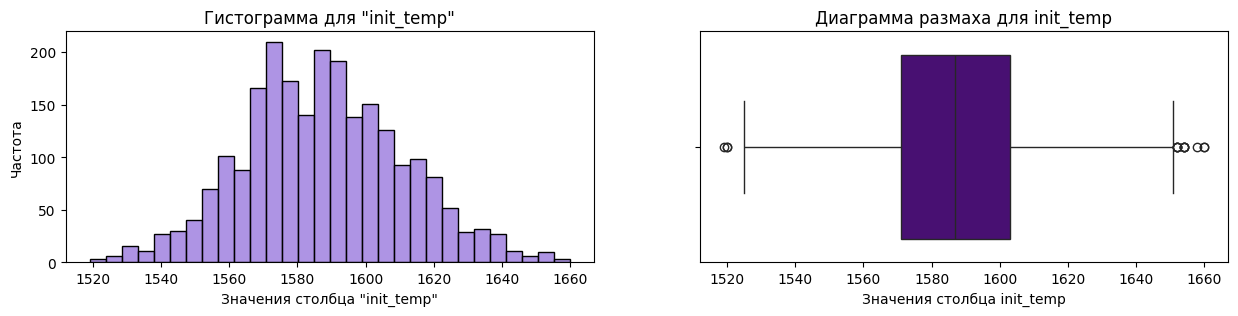

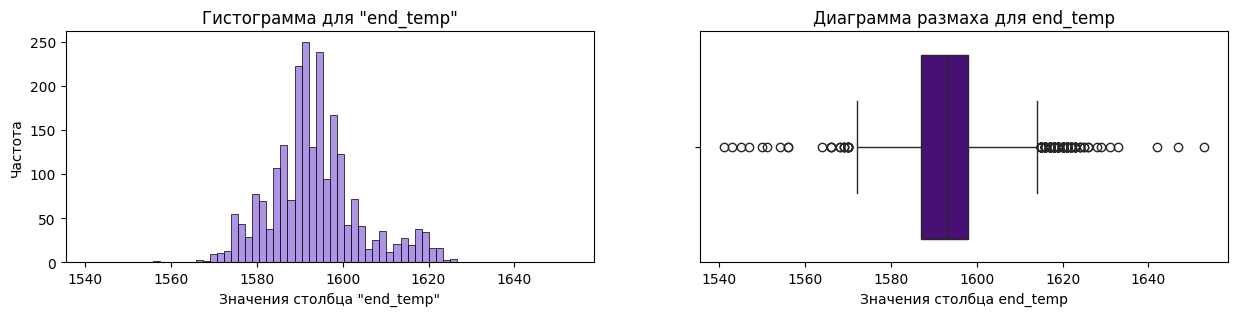

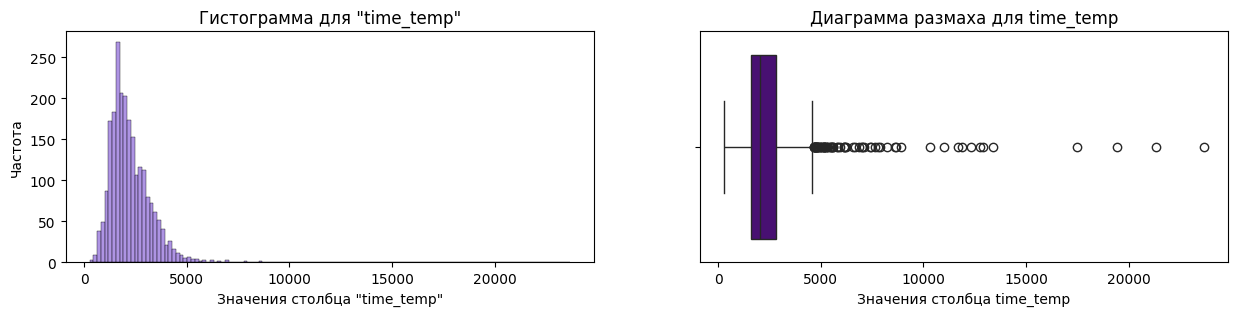

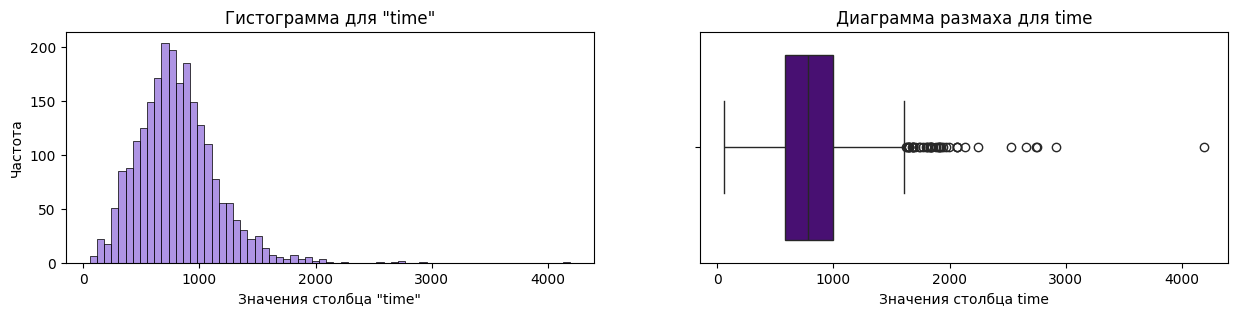

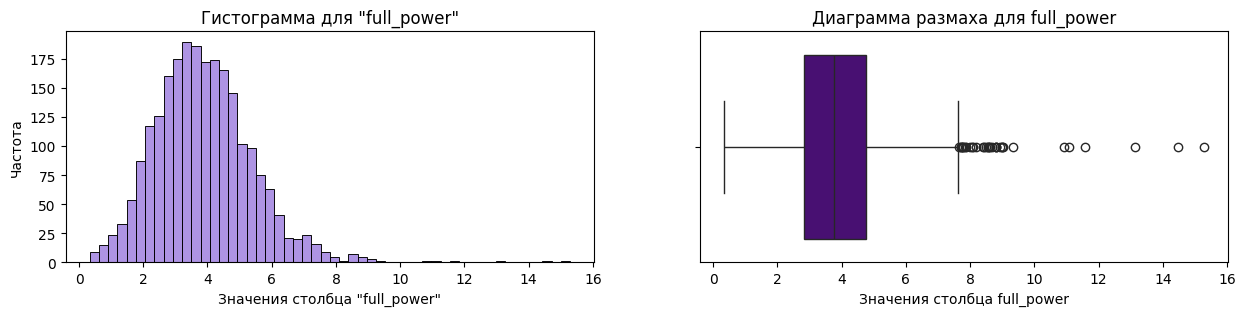

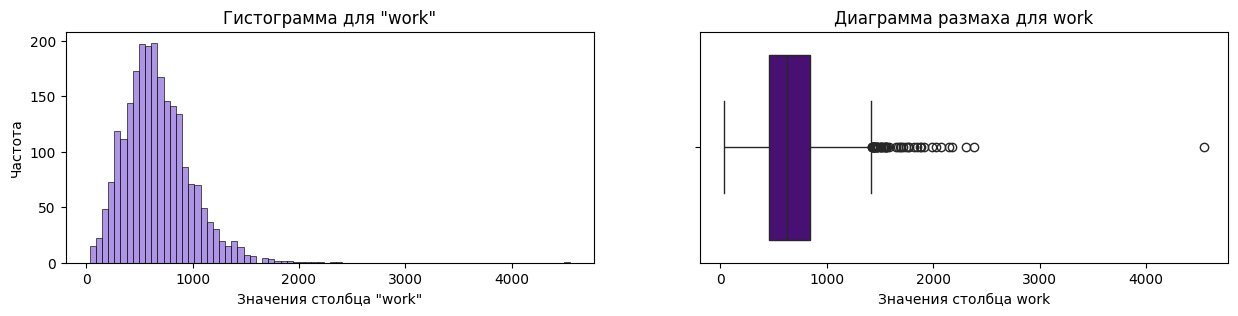

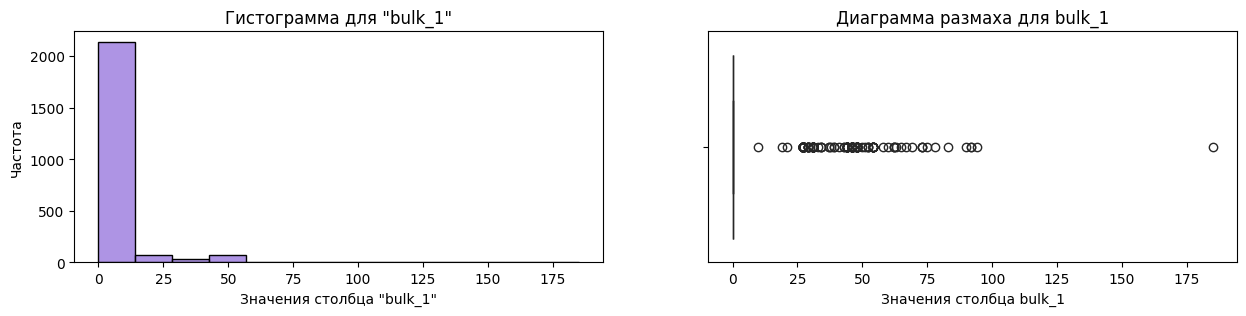

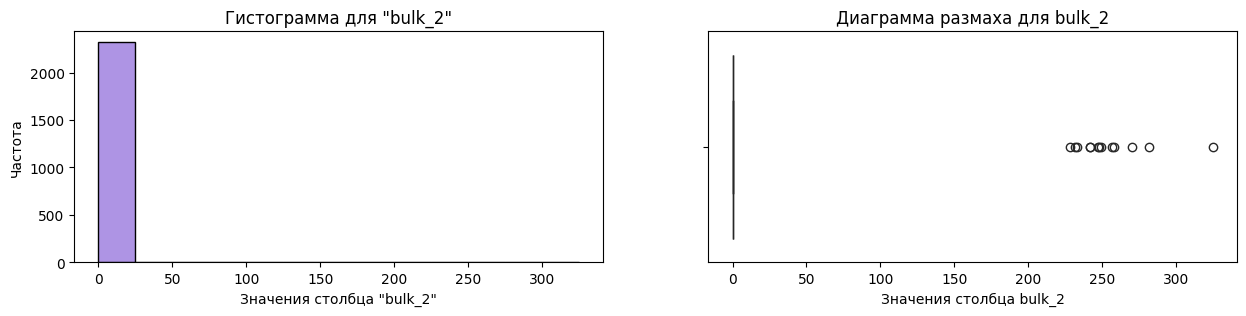

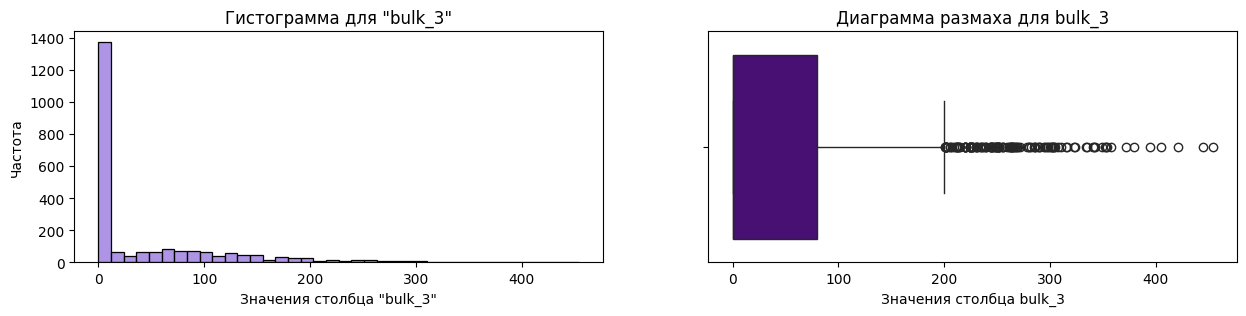

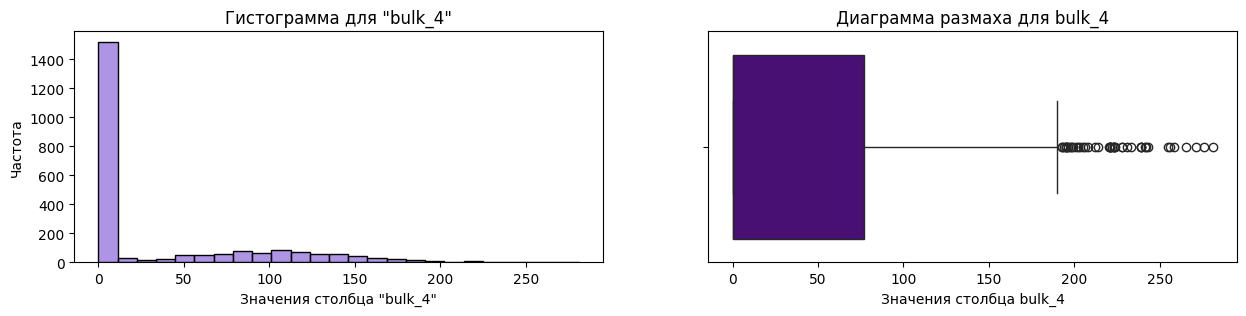

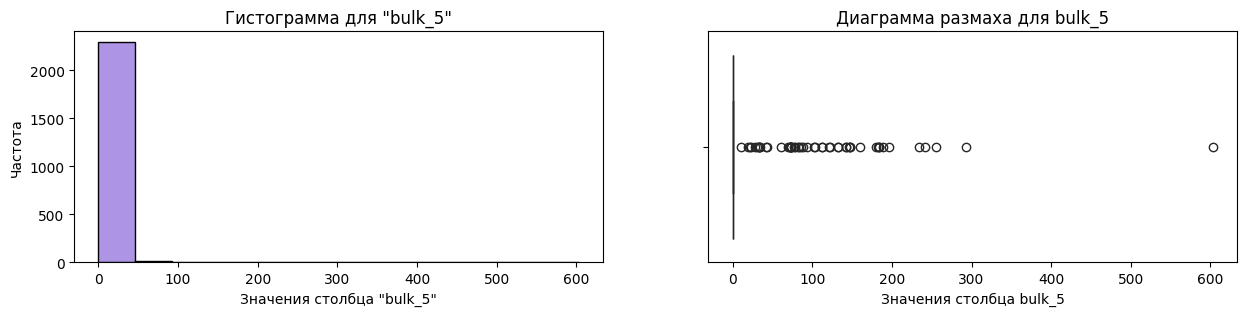

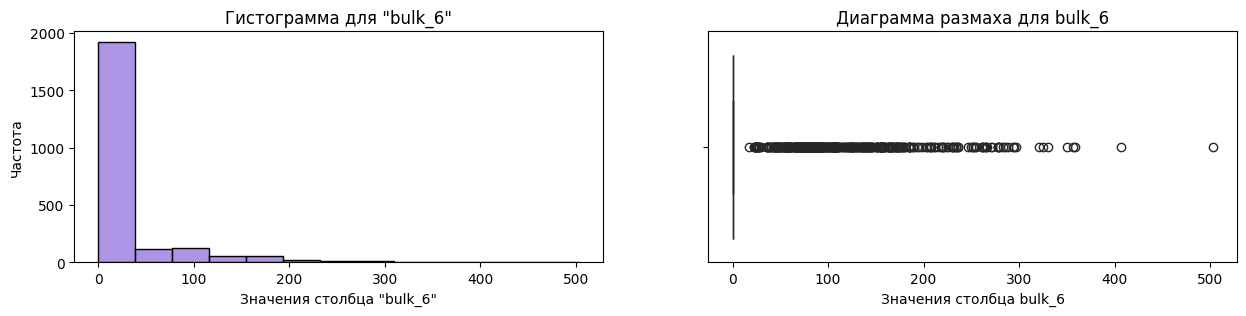

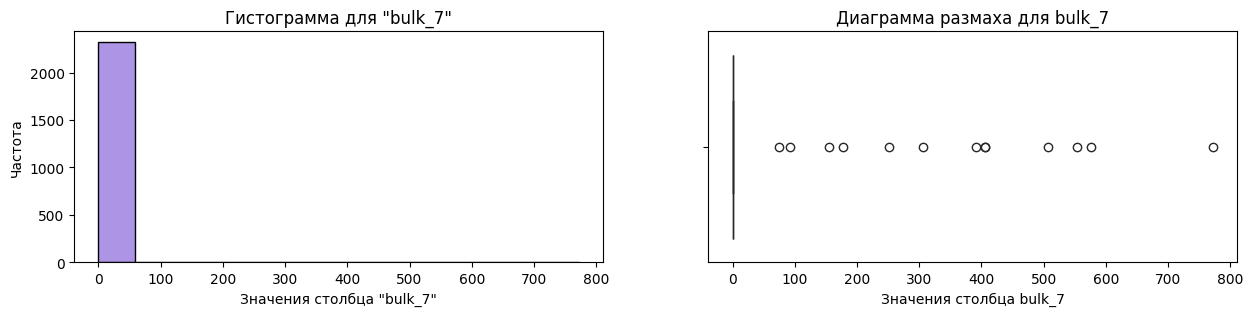

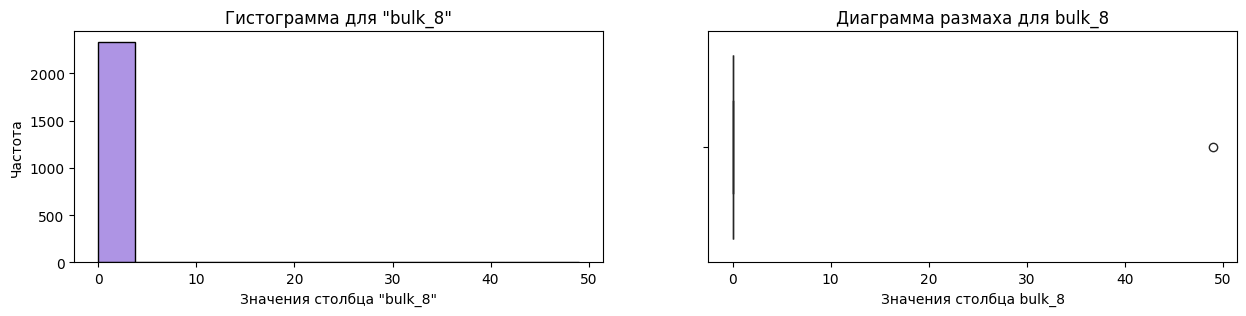

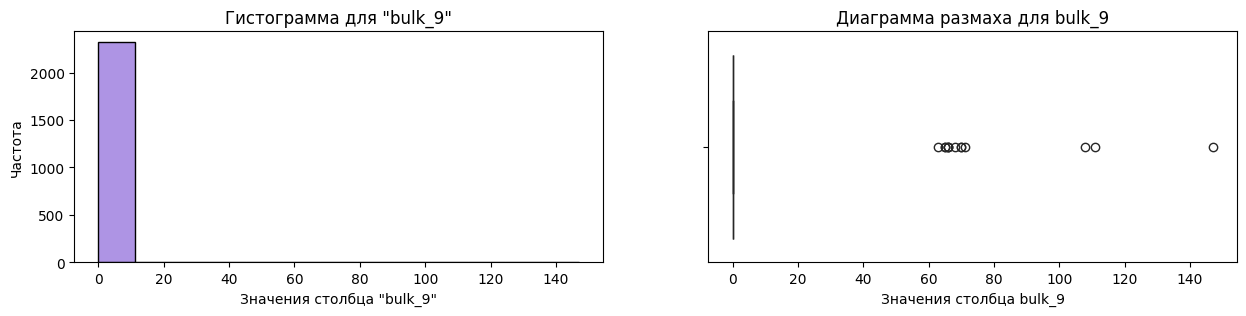

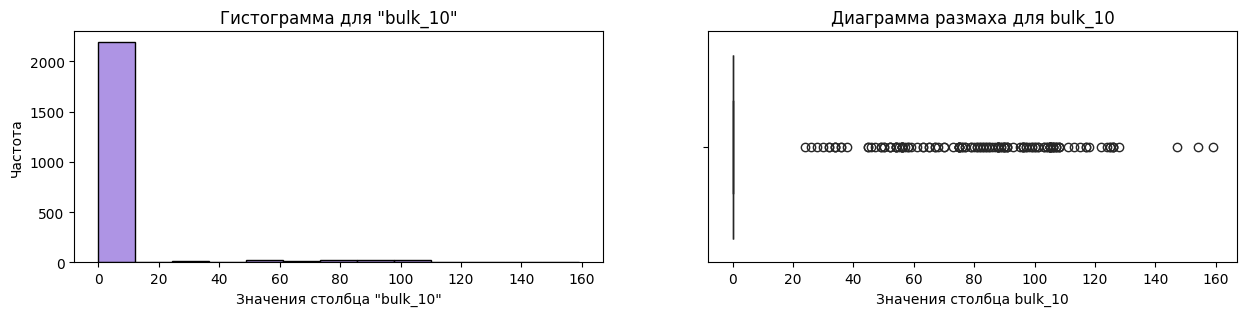

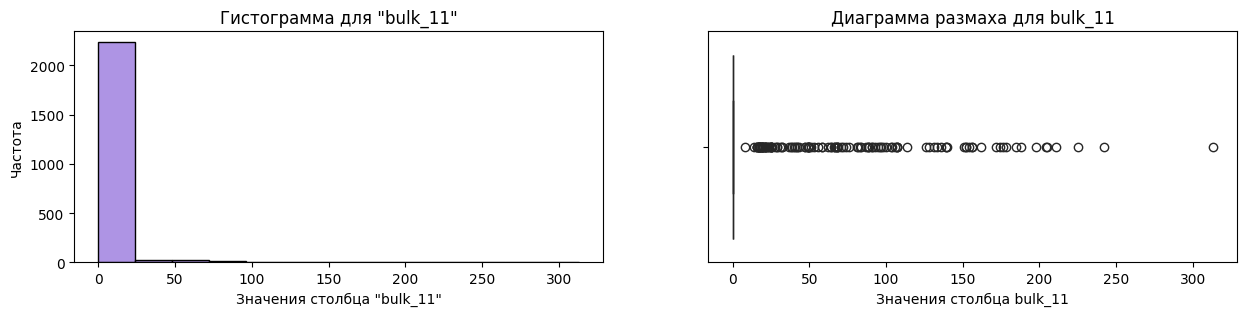

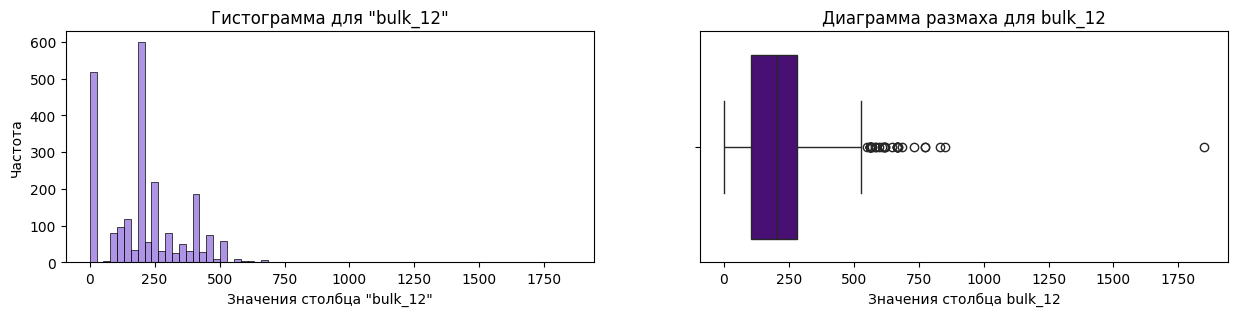

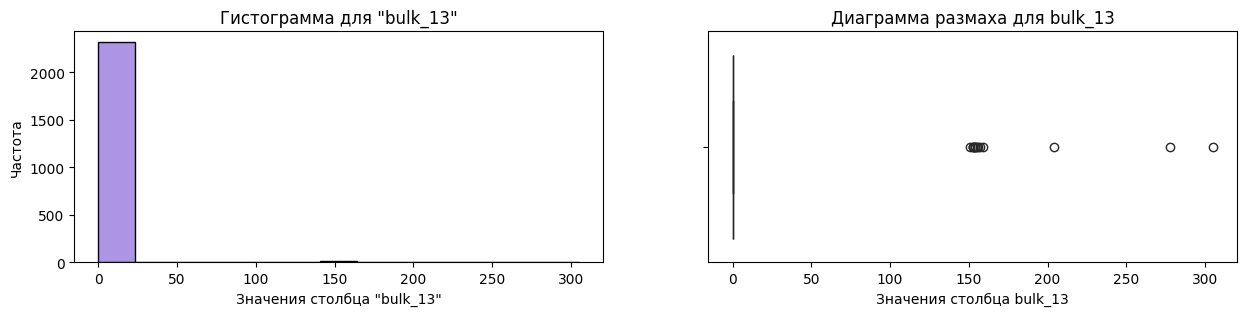

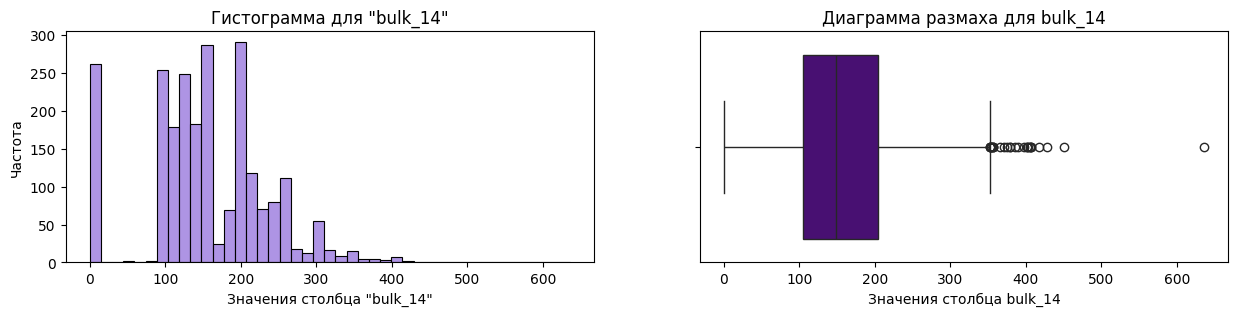

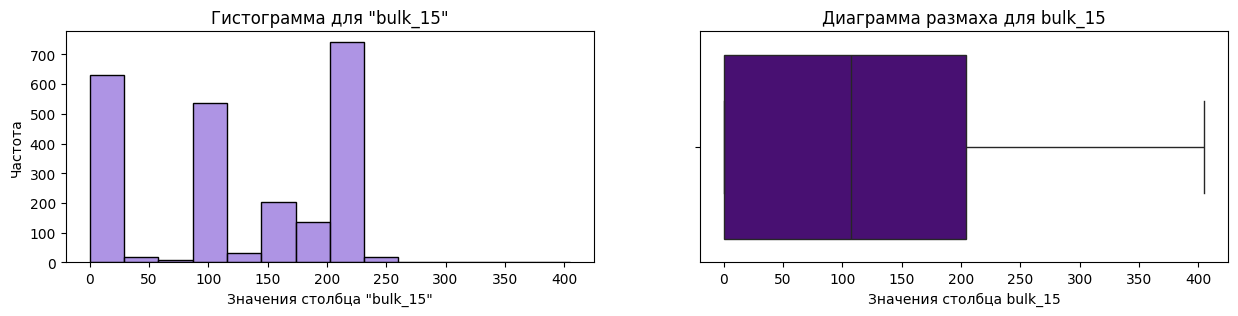

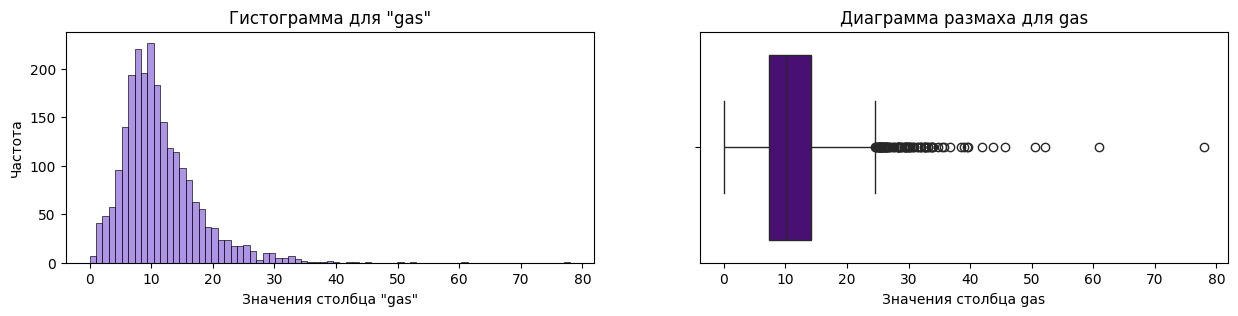

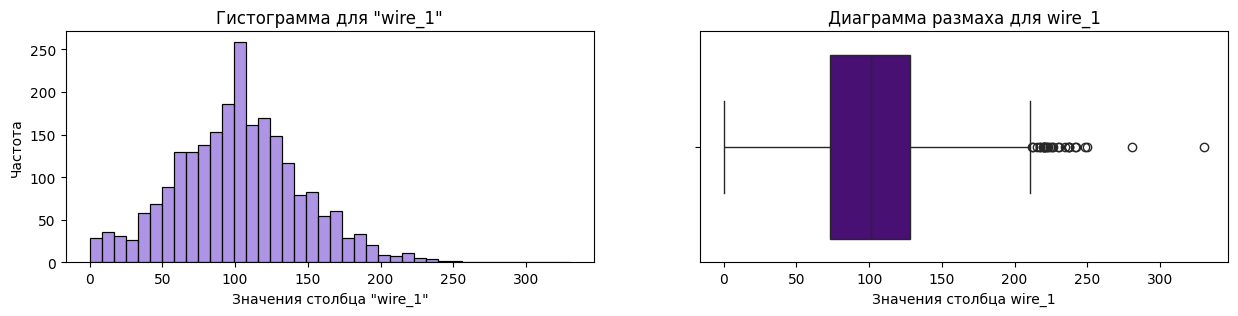

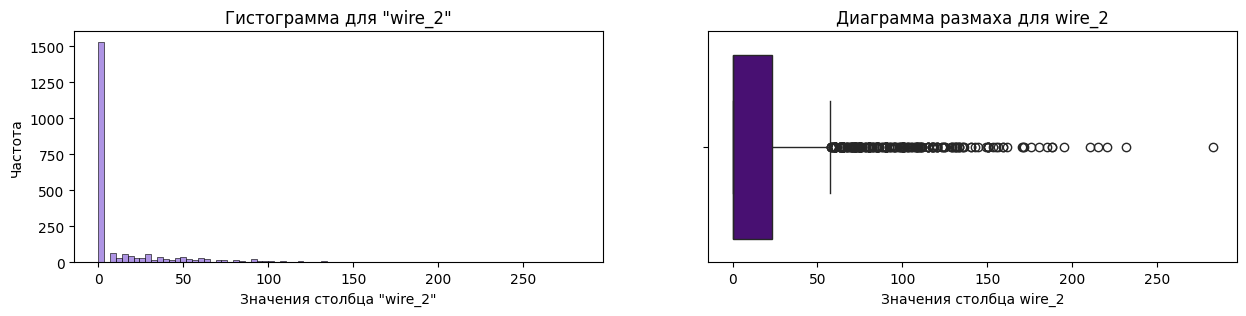

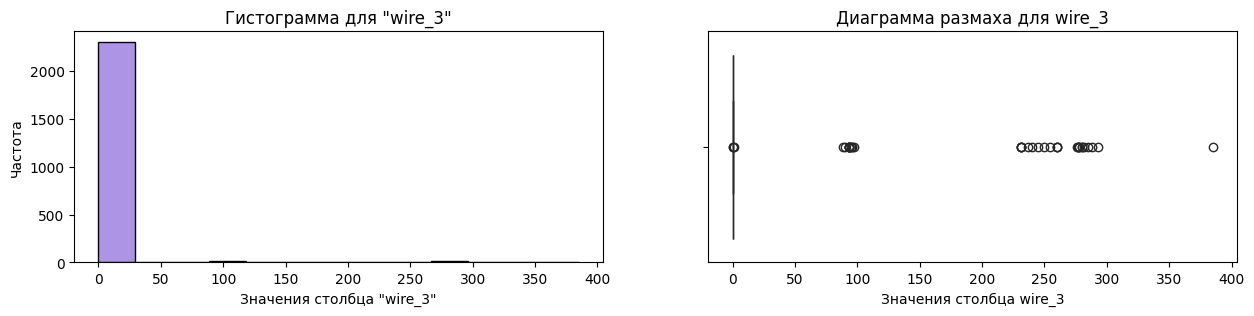

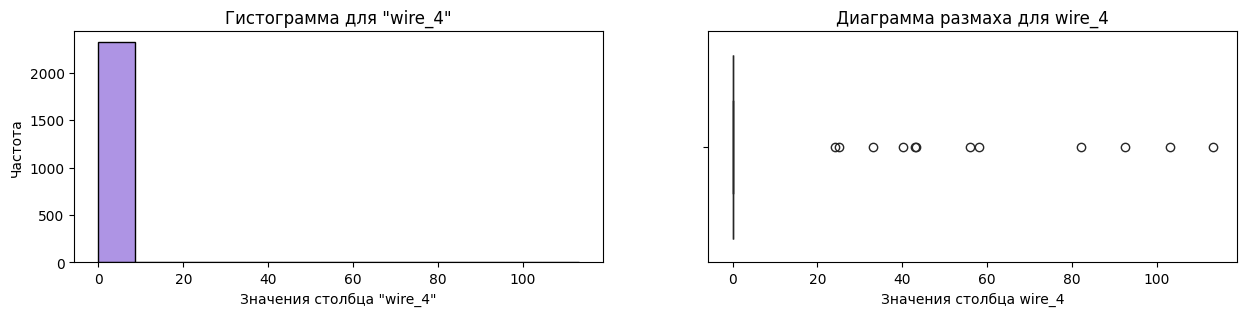

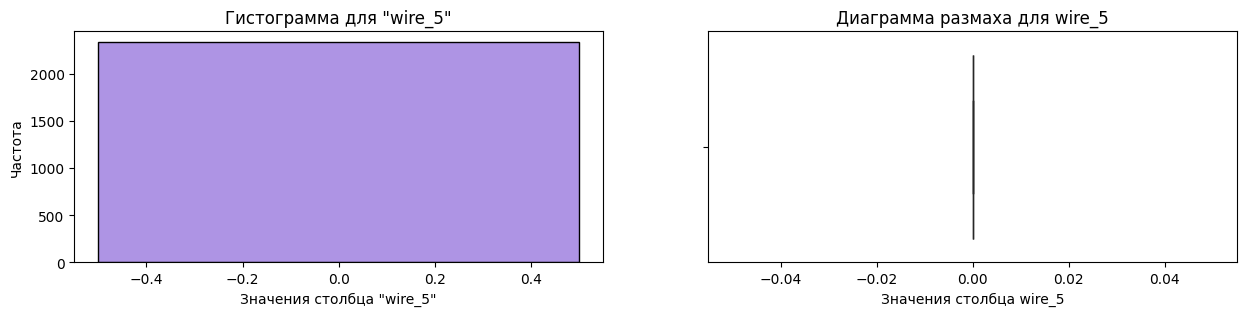

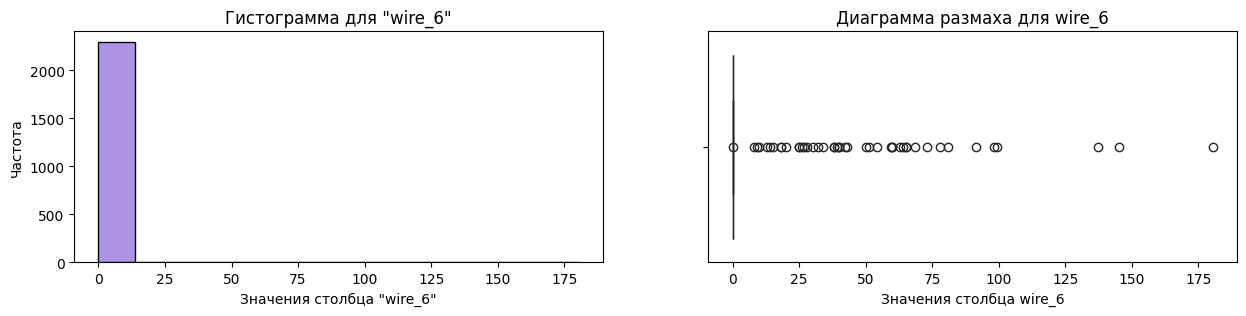

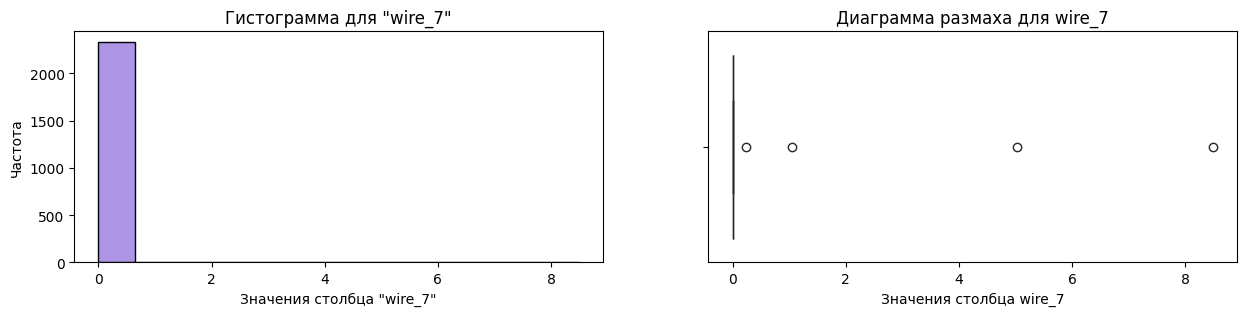

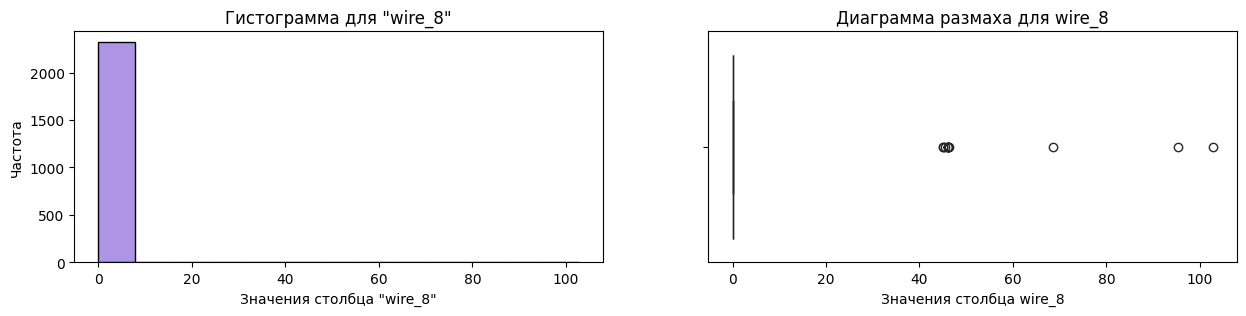

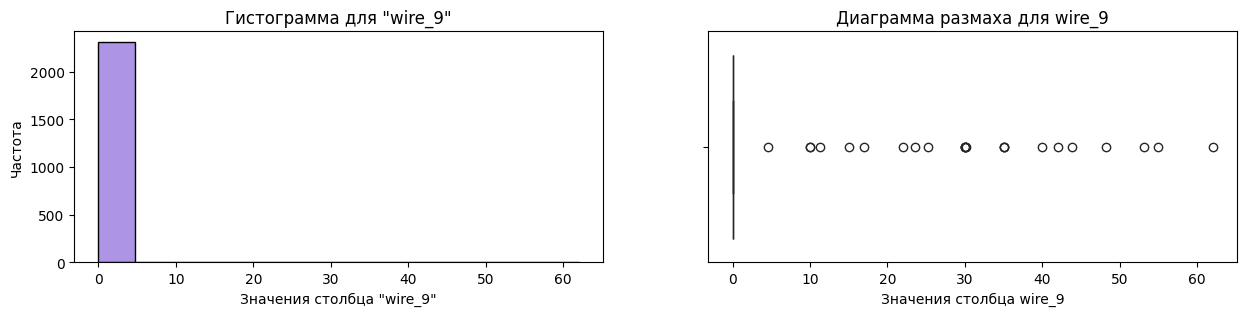

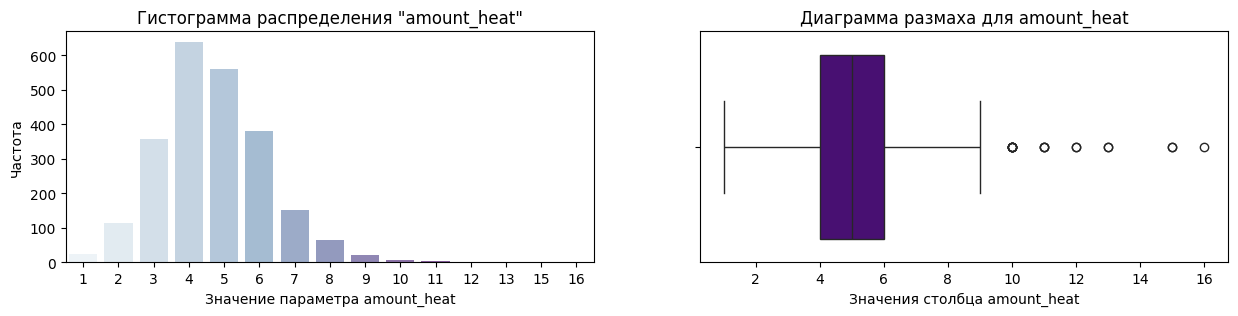

In [70]:
for name in num_col:
    hist_box(temp, name)

for name in disc_num_col:
    bar_box(temp, name)

Распределение признаков такое же как и было в таблицах до объединения - часть распределены нормально (те что связанными с температурой и мощностями), часть неравномерно (связаны с добавляемыми компонентами).

### 4.2. Корреляционный анализ

Поскольку некоторые признаки распределены неравномерно, в качестве коэффициента корреляции будем использовать коэффициент корреляции Спирмана.

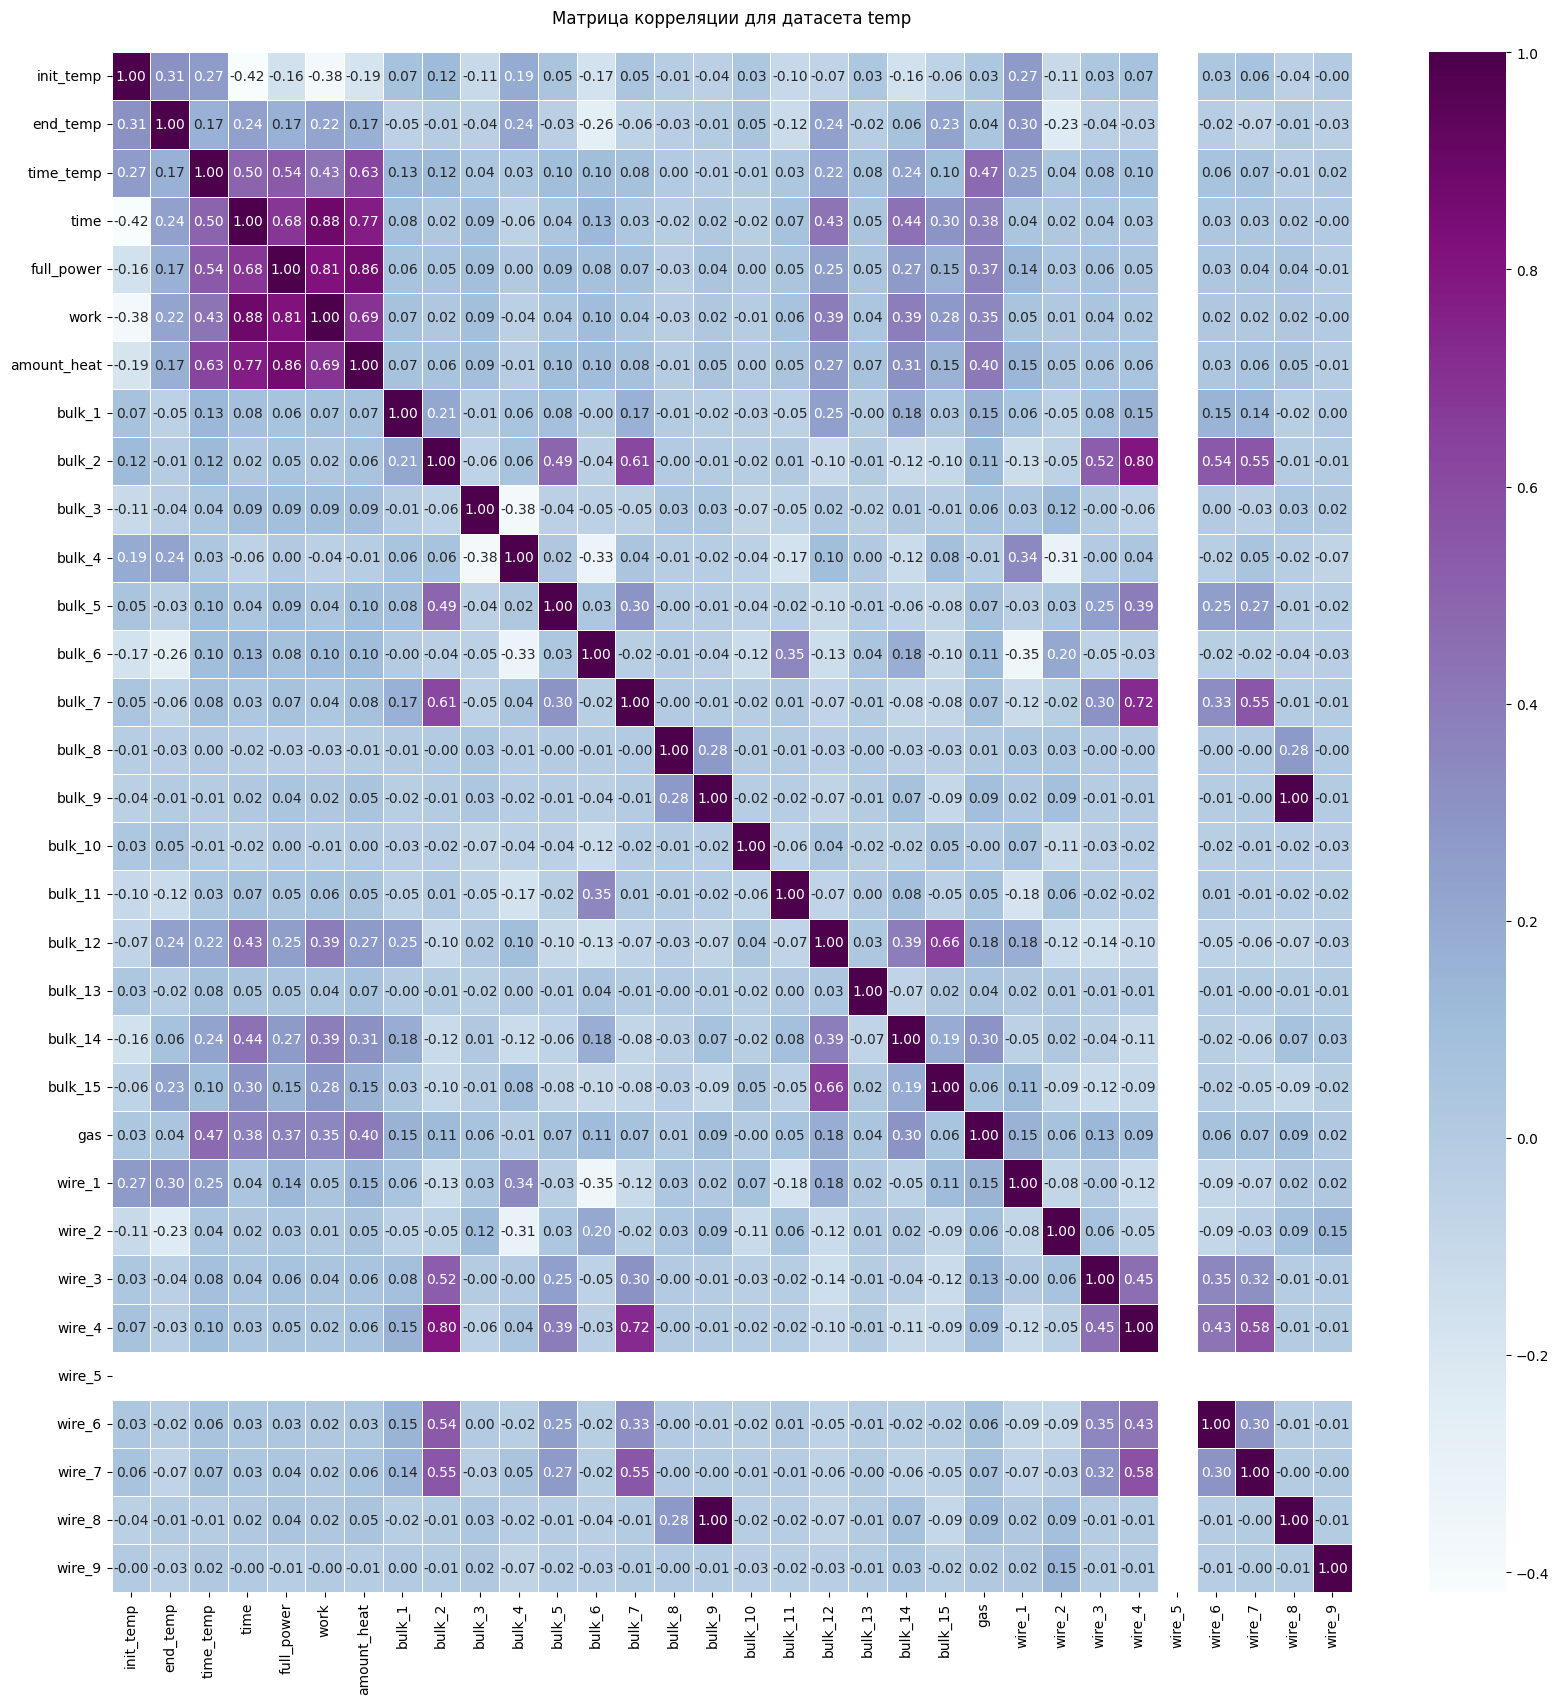

In [71]:
#вычисление матрицы корреляции
corr_matrix = temp.corr(method='spearman')

#визуализация матрицы корреляции
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', linewidth=.5, fmt=".2f")
plt.title('Матрица корреляции для датасета temp\n')
plt.show()

Все признаки не имеют корреляции с целевой переменной.

Есть полная корреляция между признаками `wire_8` и `bulk_9`. Видимо их всегда добавляют вместе. Можно сделать общий признак - сумма объёмов `wire_8` и `bulk_9`.

Некоторые признаки также коррелируют между собой, но мультиколлениарности не наблюдается.

In [72]:
temp['wb_89'] = temp['bulk_9'] + temp['wire_8']

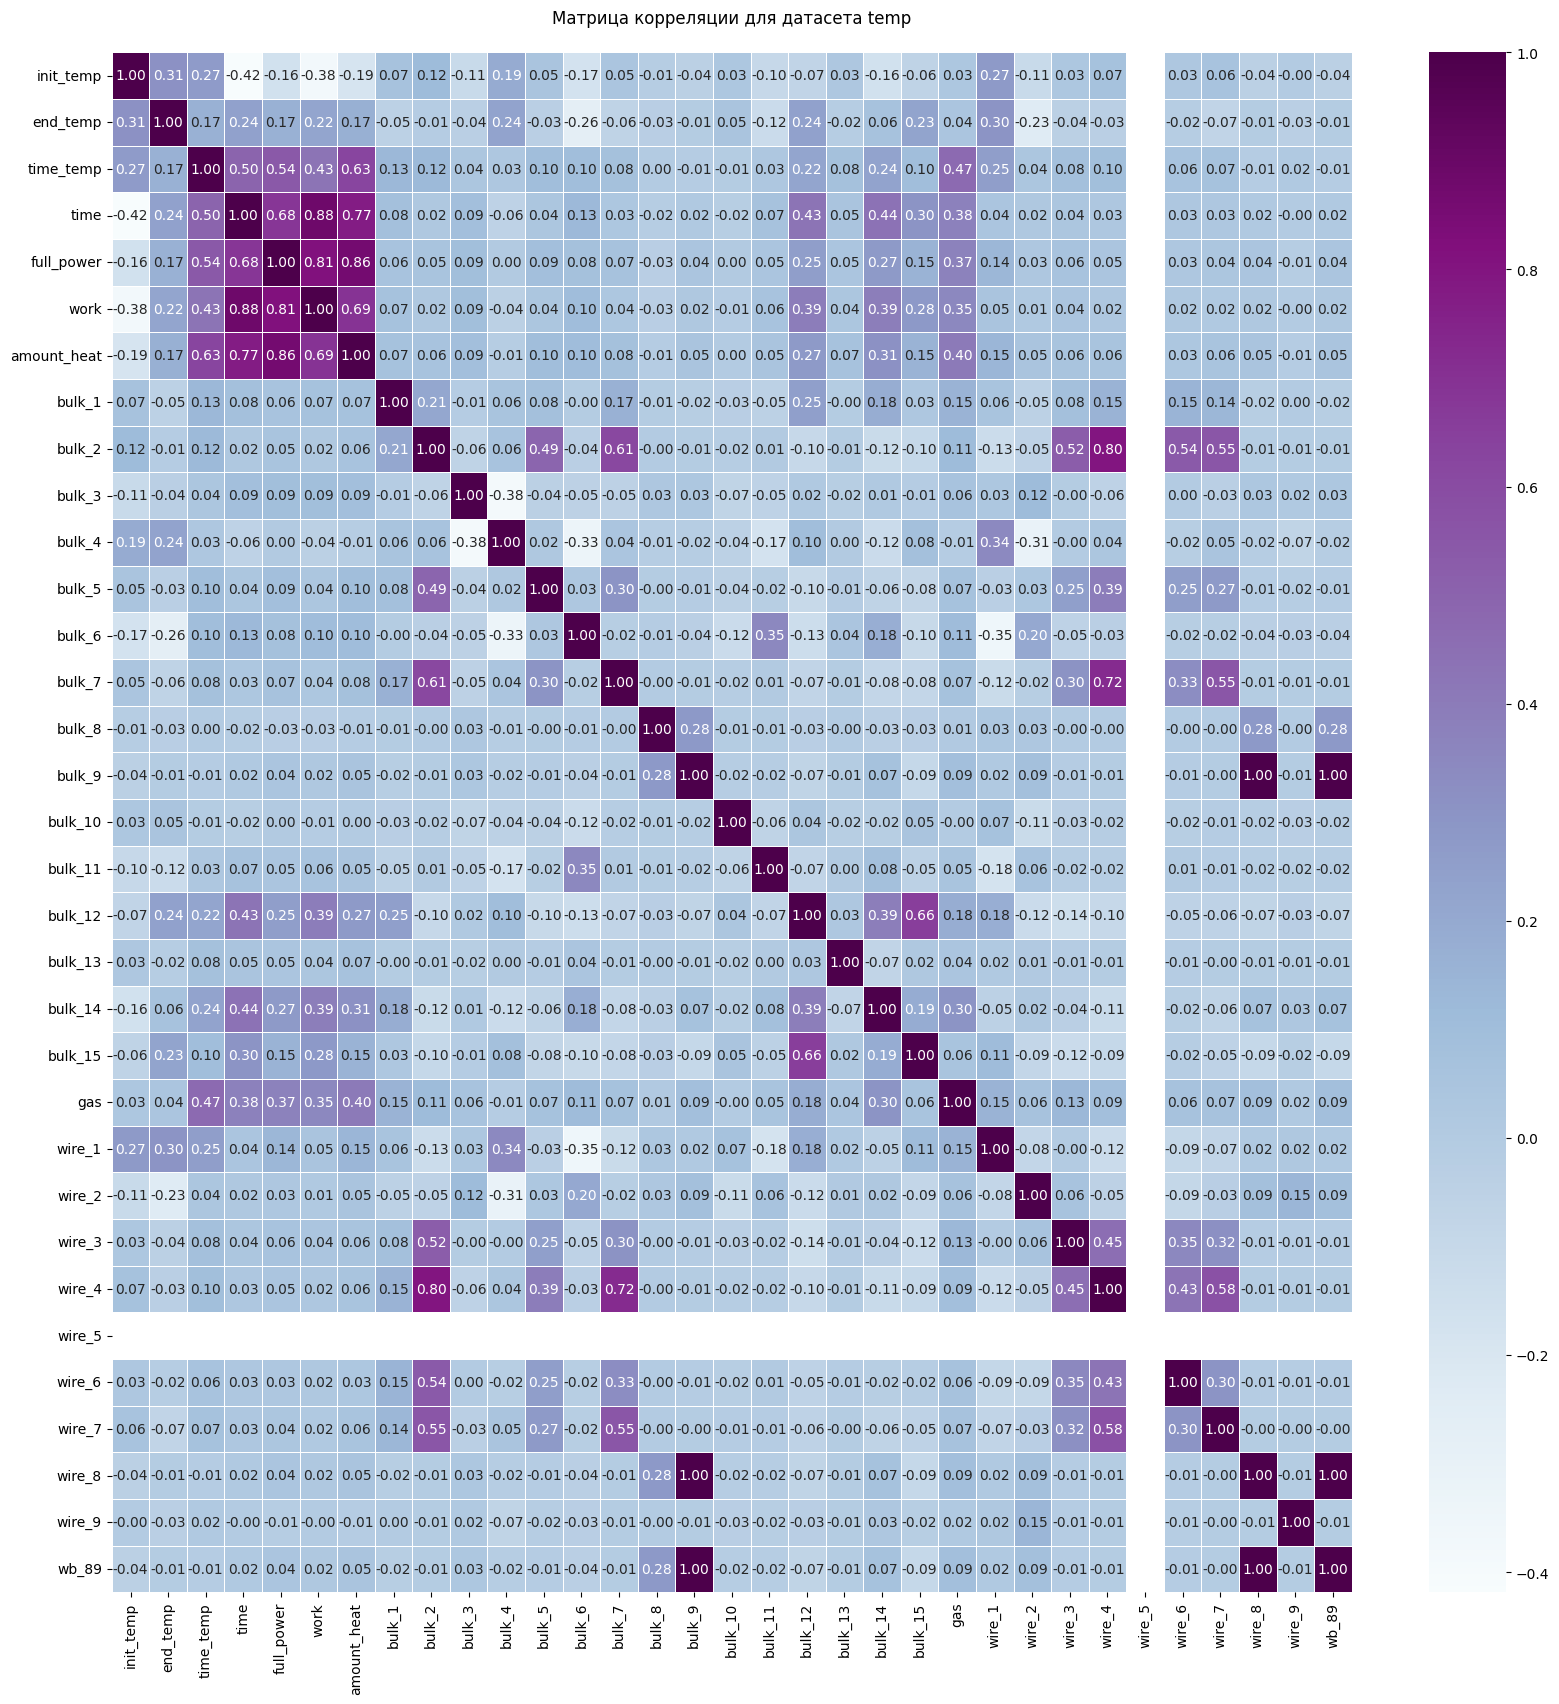

In [73]:
#вычисление матрицы корреляции
corr_matrix = temp.corr(method='spearman')

#визуализация матрицы корреляции
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', linewidth=.5, fmt=".2f")
plt.title('Матрица корреляции для датасета temp\n')
plt.show()

С целевой переменной у нового признака корреляции нет.

## 5. Подготовка данных к обучению моделей

### 5.1. Разделение на выборки

In [74]:
#разбиение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(temp.drop(['end_temp', 'wire_8', 'bulk_9'], axis=1) ,
                                                    temp['end_temp'],
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE)

### 5.2. Подготовка Pipeline

In [75]:
num_col = ['init_temp', 'time_temp',
           'time', 'full_power', 'work', 'amount_heat', 'bulk_1', 'bulk_2','bulk_3',
           'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10',
           'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1',
           'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_9', 'wb_89']

In [76]:
# Pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough'
)

In [77]:
# Итоговый Pipeline: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

## 6. Обучение моделей

### 6.1. Константная модель

In [78]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_train)

dummy_score = mean_absolute_error(y_train, y_pred)
print(f'Метрика MAE для константной модели: {round(dummy_score, 2)}')

Метрика MAE для константной модели: 8.03


### 6.2. Модель линейной регрессии

In [79]:
#Параметры для передачи RandomizedSearchCV для поиска оптимальной модели
#с разными Scaler и перебором гиперпараметров

param_dist_lin = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }]

In [80]:
#поиск оптимальной модели с перебором гиперпараметров

rand_lin = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist_lin,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

In [81]:
#обучение модели на тренировочной выборке
rand_lin.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rand_lin.best_estimator_)
print('Метрика MAE для лучшей модели:\n', round(-rand_lin.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['init_temp', 'time_temp',
                                                   'time', 'full_power', 'work',
                                                   'amount_heat', 'bulk_1',
                                                   'bulk_2', 'bulk_3', 'bulk_4',
                                                   'bulk_5', 'bulk_6', 'bulk_7',
                                                   'bulk_8', 'bulk_10',
                                                   'bulk_11', 'bulk_12',
                                                   'bulk_13', 'bulk_14',
                                                   'bulk_15', 'gas', 'wire_1',
                                                   'wire_2', 'wire_3', 'wire_4',
                          

### 6.3. Дерево решений

In [82]:
param_dist_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }]

In [83]:
rand_tree = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist_tree,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

In [84]:
#обучение модели на тренировочной выборке
rand_tree.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rand_tree.best_estimator_)
print('Метрика MAE для лучшей модели:\n', round(-rand_tree.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['init_temp', 'time_temp',
                                                   'time', 'full_power', 'work',
                                                   'amount_heat', 'bulk_1',
                                                   'bulk_2', 'bulk_3', 'bulk_4',
                                                   'bulk_5', 'bulk_6', 'bulk_7',
                                                   'bulk_8', 'bulk_10',
                                                   'bulk_11', 'bulk_12',
                                                   'bulk_13', 'bulk_14',
                                                   'bulk_15', 'gas', 'wire_1',
                                                   'wire_2', 'wire_3', 'wire_4',
                             

### 6.4. LGBMRegressor

In [85]:
#Параметры для передачи RandomizedSearchCV для поиска оптимальной модели
#с разными Scaler и перебором гиперпараметров

param_dist_lgbm = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_leaf': range(4, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [86]:
#поиск оптимальной модели с перебором гиперпараметров

rand_lgbm = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist_lgbm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [87]:
#обучение модели на тренировочной выборке
rand_lgbm.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rand_lgbm.best_estimator_)
print('Метрика MAE для лучшей модели:\n', round(-rand_lgbm.best_score_, 2))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 1746, number of used features: 27
[LightGBM] [Info] Start training from score 1593.206186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### 6.5. CatBoostRegressor

In [88]:
#Параметры для передачи RandomizedSearchCV для поиска оптимальной модели
#с разными Scaler и перебором гиперпараметров

param_dist_catboost = [
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE,
                                     verbose=False,
                                     learning_rate=0.1)],
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [89]:
#поиск оптимальной модели с перебором гиперпараметров

rand_catboost = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_dist_catboost,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [90]:
#обучение модели на тренировочной выборке
rand_catboost.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rand_catboost.best_estimator_)
print('Метрика MAE для лучшей модели:\n', round(-rand_catboost.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['init_temp', 'time_temp',
                                                   'time', 'full_power', 'work',
                                                   'amount_heat', 'bulk_1',
                                                   'bulk_2', 'bulk_3', 'bulk_4',
                                                   'bulk_5', 'bulk_6', 'bulk_7',
                                                   'bulk_8', 'bulk_10',
                                                   'bulk_11', 'bulk_12',
                                                   'bulk_13', 'bulk_14',
                                                   'bulk_15', 'gas', 'wire_1',
                                                   'wire_2', 'wire_3', 'wire_4',
                            

### 6.6. Вывод по обучению моделей

In [91]:
data = {'MAE_train':[round(dummy_score, 2),
                     round(-rand_lin.best_score_, 2),
                     round(-rand_tree.best_score_, 2),
                     round(-rand_catboost.best_score_, 2),
                     round(-rand_lgbm.best_score_, 2)]
       }

data = pd.DataFrame(data, index =['DummyRegressor',
                                  'LinearRegression',
                                  'DecisionTreeRegressor',
                                  'CatBoostRegressor',
                                  'LGBMRegressor'])

data

MAE_train
DummyRegressor              8.03
LinearRegression            5.92
DecisionTreeRegressor       7.38
CatBoostRegressor           5.84
LGBMRegressor               5.76

- Все модели показали метрику ниже, чем константная модель - значит модели сработали адекватно.
- Модель линейной регресси справилась на уровне градиентных моделей.
- Лучшей моделью оказалось модель LGBMRegressor. С помощью неё рассчитаем метрику на тестовой выборке.


In [92]:
#метрика на тестовой выборке

y_pred = rand_lgbm.best_estimator_.predict(X_test)

print('Метрика MAE для лучшей модели на тестовой выборке:\n',
      round(mean_absolute_error(y_test, y_pred), 2))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=5. Current value: min_data_in_leaf=5
Метрика MAE для лучшей модели на тестовой выборке:
 6.19


На тестовой выборке метрика составила 6,2. Порог прошли!

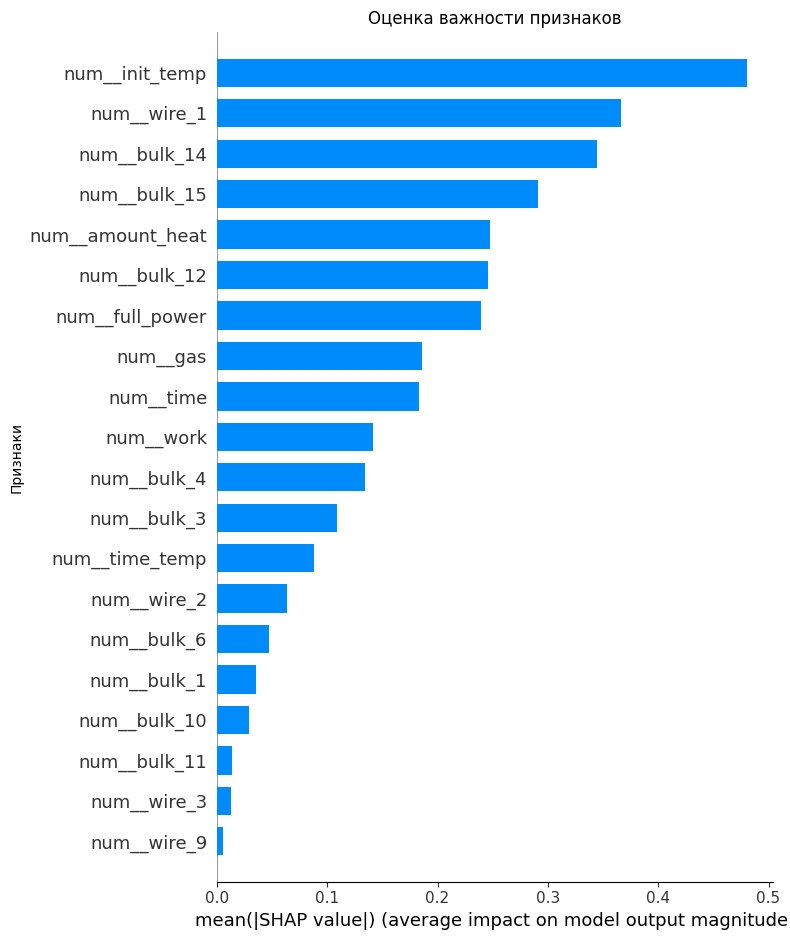

In [93]:
#поиск важных признаков
X_encoded = rand_catboost.best_estimator_['preprocessor'].fit_transform(X_train)

model = rand_catboost.best_estimator_['models'].fit(X_encoded, y_train)
explainer = shap.PermutationExplainer(model, X_encoded)


labels = rand_catboost.best_estimator_[:-1].get_feature_names_out()

plt.title('Оценка важности признаков')
plt.ylabel('Признаки')
shap.summary_plot(X_encoded, plot_type='bar', feature_names=labels)

Важными параметрами, которые не связаны с доповляемыми компонентами, можно выделить начальную температуру, количество циклов нагрева, полная мощность, работа и время между замерами температуры.

## 7. Общий вывод

В данном проекте были проанализированы данные от металлургического комбината «Стальная птица». На основе данных нужно было предложить модель, предсказывающую конечную температуру нагретой стали, с целью возможности контролировать данную температура и, соответственно, энергозатраты.

**Были выполнены следующие шаги**:
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели

В результате лучшей моделью оказалась модель LGBMRegressor со значением метрики МАЕ _5,76_ на тренировочной выборке и _6,19_ на тестовой. Данная модель удовлетворяет условиям по необходимому значению метрики.
Также была проанализирована важность признаков. Наиболее значимыми оказались признаки - начальная температура, количество циклов нагрева, полная мощность, работа и время между замерами температуры.

По-видимому, чтобы снизить затраты на электроэнергию стоит быстрее греть (меньше затрачивать времени на нагрев), стартовать с более высоких температур (более близкие к целевой конечной температуре).